In [59]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from scipy.stats import mode 
from sklearn.metrics import confusion_matrix
from sklearn import metrics

import matplotlib.pyplot as plt
from matplotlib import style

import random

In [60]:
def get_ht_new(X, Dti, no_of_Q):
    '''
    This function is used for returning the partitioning of the X's
    no_of_Q : represents the number of Q samples that must be choosen from all the M samples
    '''
    # we will extract the Q values with top Dti's
    Dti = np.array(Dti)
    ind_max = np.argpartition(Dti, -no_of_Q)[-no_of_Q:]

#     no of paritions = 3
    no_of_paritons = 3
#     km = KMeans(
#         n_clusters=no_of_paritons, init='random',
#         n_init=10, max_iter=10000,
#         tol=1e-01, random_state=8)


    km = KMeans(
        n_clusters=no_of_paritons, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0)

    # now we will pass the corresponding X and parts with the Q samples to train the model 
    fitted_km = km.fit(X[ind_max])
    # prediction will be obtained for all the samples
    prediction = fitted_km.predict(X)
    d = prediction

    return  d, fitted_km

In [61]:
def final_bin_predictions(X,y_mod,Dti,betas):
    '''
    used for calculating the value of H(x) from the beta values
    '''
    Hx = np.sum(betas, axis = 0)
    
    final_bin = []

    for j in range(len(Hx)):
      if np.sign(Hx[j]) == -1:
        final_bin.append(-1)
      elif np.sign(Hx[j]) == 1:
        final_bin.append(1)
      else:
        final_bin.append(random.choice([-1,1]))
    
    acc = metrics.accuracy_score(final_bin, y_mod)
    
    
    return final_bin, acc

In [62]:
def realboost(X, y, T ,C):

  Dt = []
  Dt.append(np.full(len(X), 1/len(X)))
  y_mod = np.full(len(y), 1)
  y_mod[np.where(np.array(y) == 0)] = -1
  print('y_mod', y_mod)
  beta_jt = []
  classifiers = []
  accuracies = []

  for t in range(T):

    print('-----------------------ITERATION {} -------------------------'.format(t+1))
    print(' ')

    beta_t = []
    Dti = Dt[t]
    no_of_Q = 4
    preds, c = get_ht_new(X, Dti, no_of_Q)

    print('Weak Hypothesis : ', preds)
    print(' ')

    classifiers.append(c)

    beta_t = []

    Zt = 0
    for k in range(C):

      w0 = 1e-8
      w1 = 1e-8

      for i in range(len(preds)):

        if y_mod[i] == -1 and preds[i] == k:
          w0 += Dti[i] 

        if y_mod[i] == 1 and preds[i] == k:
          w1 += Dti[i]

      beta_k = np.log(w1/w0)/2

      beta_t.append(beta_k)
      Zt += np.sqrt(w0*w1)
    
    Zt = 2*Zt
    print('Zt value : ', Zt)
    print(' ')

    print('Beta values at iteration : ', beta_t)
    print(' ')

    beta_jti = []
    for i in range(len(X)):
      for k in range(C):
        if preds[i] == k:
          beta_jti.append(beta_t[k])
    
    print('Beta values for each sample at iteration : ', beta_jti)
    print(' ')
    beta_jt.append(beta_jti)

    # Distribution Update
    for i in range(len(X)):
      
      Dti[i] = Dti[i]*np.exp(-beta_jt[t][i]*y_mod[i])/Zt

    Dt.append(Dti)

    #Strong Hypothesis
    final_bin, acc = final_bin_predictions(X,y_mod,Dt[t],beta_jt)
    print('Strong Hypothesis : ', final_bin)
    print(' ')
    print('Instantaneous Accuracy : ', acc)
    print(' ')
    accuracies.append(acc)

  return Dt, beta_jt, accuracies, classifiers, Zt


In [63]:
def testing(classifiers, Beta_j, X, y, No_of_itr, no_of_Q):
    '''
    here beta_j is the function which is contains the betas in the form - [[beta0,beta1,beta2]itr=1,[beta0,beta1,beta2]itr=2,[beta0,beta1,beta2]itr=3....]
    
    '''

    T = No_of_itr
    #change labels from 0,1 to -1,1
    y_mod = np.full(len(y), 1)
    y_mod[np.where(np.array(y) == 0)] = -1
    
    ## lets do the partitioning to produce domains
    Dti = np.full(len(X),1/len(X))
    
    Beta_js = [] # the array which will store all the betas
    accuracy_final_test= []
    for i in range(T):
        beta_j = Beta_j[i]
        predst = classifiers[i].predict(X)
        print(predst)
        final_beta =[]

        # updation of dti and distribution of betas
        for i in range(len(X)):
            if(predst[i]==0):
                final_beta.append(beta_j[0])

            elif(predst[i]==1):
                final_beta.append(beta_j[1])

            else:
                final_beta.append(beta_j[2])
            
        Beta_js.append(final_beta)
            
        final_bin, acc = final_bin_predictions(X,y_mod,Dti,Beta_js)
        accuracy_final_test.append(acc)
            
    import matplotlib.pyplot as plt
    from matplotlib import style
        
    return Beta_js, accuracy_final_test

In [64]:
def plot_fn(acc, T, M, ds, Algo, train_test):
    
    plt.style.use('seaborn')
    plt.plot(list(range(T)), acc)
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.title("{} {} {} Accuracy M={}".format(Algo,ds, train_test, M))
    plt.show()

# Breast Cancer

## M=64

In [65]:
X = np.array([[-0.92033957],
       [-0.62676039],
       [-0.28869688],
       [-0.4545198 ],
       [-0.5639226 ],
       [-0.13063581],
       [-0.12721978],
       [-0.84393553],
       [-0.8167348 ],
       [-0.86877809],
       [ 0.68405998],
       [-0.77438584],
       [-0.72603092],
       [-0.97403678],
       [ 0.82394382],
       [ 0.04393449],
       [-0.62029416],
       [-0.7575307 ],
       [-0.78364214],
       [-0.69133675],
       [ 0.4711372 ],
       [-0.86332019],
       [-0.7846598 ],
       [-0.97647863],
       [-0.91662612],
       [-0.9170126 ],
       [-0.79788711],
       [-0.92582589],
       [ 0.00207795],
       [-0.94046638],
       [ 0.28818783],
       [-0.85261899],
       [-0.26015489],
       [-0.81450528],
       [-0.66534136],
       [-0.99248397],
       [-0.71814302],
       [-0.85732167],
       [-0.40941704],
       [-0.26379642],
       [ 0.00921227],
       [-0.8450853 ],
       [-0.81489227],
       [-0.59669884],
       [-0.73294047],
       [-0.88816995],
       [ 0.09926307],
       [-0.88024481],
       [-0.71913121],
       [ 0.16490514],
       [-0.68072081],
       [-0.83252443],
       [-0.59845984],
       [ 0.06816907],
       [-0.75077876],
       [-0.67732812],
       [ 1.        ],
       [-0.51626161],
       [-0.65711506],
       [-0.73442944],
       [-0.86852521],
       [-0.75947735],
       [-0.63011559],
       [-0.77908732]])

y = np.array([1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1])


X_test = np.array([[-0.75423437],
       [-0.65602419],
       [ 0.21333776],
       [-0.51939951],
       [-0.81243976],
       [-0.79156646],
       [-0.80595879],
       [-0.69137113],
       [-0.79167719],
       [-0.63640346],
       [-0.65655968],
       [-0.60008819],
       [ 0.08046681],
       [-0.66995772],
       [-0.9143032 ],
       [-0.7346537 ],
       [-0.83086306],
       [-0.69154759],
       [-0.32046433],
       [-0.61913998],
       [-0.99949378],
       [ 0.32645699],
       [-0.9091592 ],
       [-0.38972082],
       [-0.836701  ],
       [-0.23793032],
       [-0.6540042 ],
       [-0.86902482],
       [-0.804716  ],
       [ 0.1423963 ],
       [-0.68438072],
       [-0.90523266],
       [-0.06363657],
       [ 0.13351811],
       [-0.8986342 ],
       [-0.67632821],
       [-0.83384046],
       [-0.24302343],
       [-0.11478386],
       [-0.1748094 ],
       [-0.59596087],
       [-0.83984607],
       [-0.57101925],
       [-0.72698474],
       [-0.67562877],
       [-0.41587335],
       [-1.        ],
       [-0.75527322],
       [-0.78762551],
       [ 0.15402963],
       [-0.24211366],
       [-0.75569997],
       [-0.63144063],
       [-0.82345331],
       [-0.81198364],
       [-0.58035185],
       [ 0.26857311],
       [-0.74967687],
       [ 0.39268594],
       [-0.46482929],
       [-0.80117135],
       [-0.32990005],
       [-0.97846964],
       [-0.75533414]])


y_test = np.array([1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1])

In [66]:
Dt, beta_jt, accuracies, classifiers, Zt = realboost(X, y, T=25 ,C=3)

y_mod [ 1  1 -1 -1  1 -1 -1  1  1  1 -1  1  1  1 -1 -1 -1  1  1  1 -1  1  1  1
  1  1 -1  1 -1  1 -1  1 -1  1  1  1 -1  1  1 -1 -1  1  1  1  1  1 -1  1
  1 -1 -1  1  1 -1  1  1 -1 -1  1  1  1  1 -1  1]
-----------------------ITERATION 1 -------------------------
 
Weak Hypothesis :  [0 1 1 1 1 1 1 0 2 0 1 2 1 0 1 1 1 1 2 1 1 0 2 0 0 0 2 0 1 0 1 0 1 2 1 0 1
 0 1 1 1 0 2 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 2]
 
Zt value :  0.6690878149589835
 
Beta values at iteration :  [8.576084727022206, -0.1592268601047221, 0.9729548002420426]
 
Beta values for each sample at iteration :  [8.576084727022206, -0.1592268601047221, -0.1592268601047221, -0.1592268601047221, -0.1592268601047221, -0.1592268601047221, -0.1592268601047221, 8.576084727022206, 0.9729548002420426, 8.576084727022206, -0.1592268601047221, 0.9729548002420426, -0.1592268601047221, 8.576084727022206, -0.1592268601047221, -0.1592268601047221, -0.1592268601047221, -0.1592268601047221, 0.9729548002420426, -0.1592268601047221, -0.15

Weak Hypothesis :  [0 2 1 1 2 1 1 0 0 0 1 0 2 0 1 1 2 0 0 2 1 0 0 0 0 0 0 0 1 0 1 0 1 0 2 0 2
 0 1 1 1 0 0 2 2 0 1 0 2 1 2 0 2 1 0 2 1 1 2 2 0 0 2 0]
 
Zt value :  1.0
 
Beta values at iteration :  [-1.1102230246251568e-16, -1.1102230246251568e-16, 1.1102230246251564e-16]
 
Beta values for each sample at iteration :  [-1.1102230246251568e-16, 1.1102230246251564e-16, -1.1102230246251568e-16, -1.1102230246251568e-16, 1.1102230246251564e-16, -1.1102230246251568e-16, -1.1102230246251568e-16, -1.1102230246251568e-16, -1.1102230246251568e-16, -1.1102230246251568e-16, -1.1102230246251568e-16, -1.1102230246251568e-16, 1.1102230246251564e-16, -1.1102230246251568e-16, -1.1102230246251568e-16, -1.1102230246251568e-16, 1.1102230246251564e-16, -1.1102230246251568e-16, -1.1102230246251568e-16, 1.1102230246251564e-16, -1.1102230246251568e-16, -1.1102230246251568e-16, -1.1102230246251568e-16, -1.1102230246251568e-16, -1.1102230246251568e-16, -1.1102230246251568e-16, -1.1102230246251568e-16, -1.1102230

Weak Hypothesis :  [0 2 1 1 2 1 1 0 0 0 1 0 2 0 1 1 2 0 0 2 1 0 0 0 0 0 0 0 1 0 1 0 1 0 2 0 2
 0 1 1 1 0 0 2 2 0 1 0 2 1 2 0 2 1 0 2 1 1 2 2 0 0 2 0]
 
Zt value :  1.0
 
Beta values at iteration :  [0.0, 0.0, 0.0]
 
Beta values for each sample at iteration :  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 
Strong Hypothesis :  [1, -1, -1, -1, -1, -1, -1, 1, 1, 1, -1, 1, 1, 1, -1, -1, -1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, -1, 1, 1, 1, 1, 1, -1, -1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, 1, 1, -1, 1]
 
Instantaneous Accuracy :  0.875
 
-----------------------ITERATION 21 -------------------------
 
Weak Hypothesis :  [0 2 1 1 2 1 1 0 0 0 1 0 2 0 1 1 2 0 0 2 1 0 0 0 0 0 0 0 1 

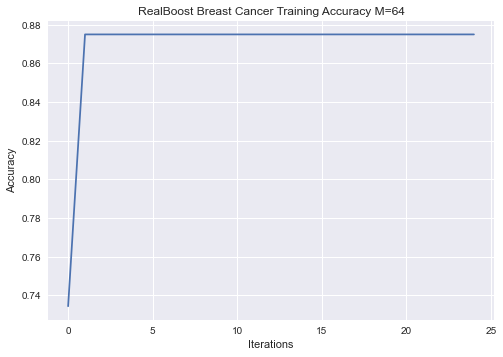

In [67]:
plot_fn(accuracies, 25, 64, ds = 'Breast Cancer', Algo= 'RealBoost', train_test = 'Training')

In [68]:
Dt, beta_jt, accuracies, classifiers, Zt = realboost(X, y, T=25 ,C=3)

y_mod [ 1  1 -1 -1  1 -1 -1  1  1  1 -1  1  1  1 -1 -1 -1  1  1  1 -1  1  1  1
  1  1 -1  1 -1  1 -1  1 -1  1  1  1 -1  1  1 -1 -1  1  1  1  1  1 -1  1
  1 -1 -1  1  1 -1  1  1 -1 -1  1  1  1  1 -1  1]
-----------------------ITERATION 1 -------------------------
 
Weak Hypothesis :  [0 1 1 1 1 1 1 0 2 0 1 2 1 0 1 1 1 1 2 1 1 0 2 0 0 0 2 0 1 0 1 0 1 2 1 0 1
 0 1 1 1 0 2 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 2]
 
Zt value :  0.6690878149589835
 
Beta values at iteration :  [8.576084727022206, -0.1592268601047221, 0.9729548002420426]
 
Beta values for each sample at iteration :  [8.576084727022206, -0.1592268601047221, -0.1592268601047221, -0.1592268601047221, -0.1592268601047221, -0.1592268601047221, -0.1592268601047221, 8.576084727022206, 0.9729548002420426, 8.576084727022206, -0.1592268601047221, 0.9729548002420426, -0.1592268601047221, 8.576084727022206, -0.1592268601047221, -0.1592268601047221, -0.1592268601047221, -0.1592268601047221, 0.9729548002420426, -0.1592268601047221, -0.15

Weak Hypothesis :  [0 2 1 1 2 1 1 0 0 0 1 0 2 0 1 1 2 0 0 2 1 0 0 0 0 0 0 0 1 0 1 0 1 0 2 0 2
 0 1 1 1 0 0 2 2 0 1 0 2 1 2 0 2 1 0 2 1 1 2 2 0 0 2 0]
 
Zt value :  1.0
 
Beta values at iteration :  [0.0, 0.0, 0.0]
 
Beta values for each sample at iteration :  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 
Strong Hypothesis :  [1, -1, -1, -1, -1, -1, -1, 1, 1, 1, -1, 1, 1, 1, -1, -1, -1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, -1, 1, 1, 1, 1, 1, -1, -1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, 1, 1, -1, 1]
 
Instantaneous Accuracy :  0.875
 
-----------------------ITERATION 17 -------------------------
 
Weak Hypothesis :  [0 2 1 1 2 1 1 0 0 0 1 0 2 0 1 1 2 0 0 2 1 0 0 0 0 0 0 0 1 

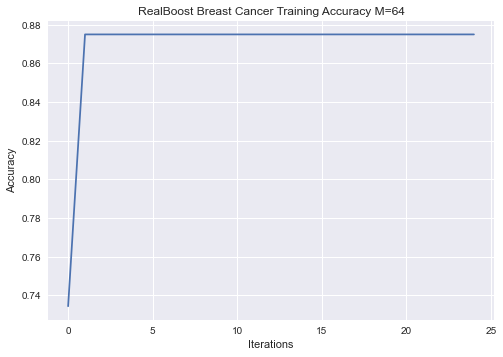

In [69]:
plot_fn(accuracies, 25, 64, ds = 'Breast Cancer', Algo= 'RealBoost', train_test = 'Training')

In [70]:
beta, test_acc = testing(classifiers, beta_jt, X_test, y_test, 25, 4)

[1 1 1 1 2 2 2 1 2 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 1 1 0 2 1 1 0 1 1 0 1 0
 1 1 1 1 0 1 1 1 1 0 1 2 1 1 1 1 0 2 1 1 1 1 1 2 1 0 1]
[0 0 2 2 1 1 1 0 1 2 0 2 2 0 1 0 1 0 2 2 1 2 1 2 1 2 0 1 1 2 0 1 2 2 1 0 1
 2 2 2 2 1 2 0 0 2 1 0 1 2 2 0 2 1 1 2 2 0 2 2 1 2 1 0]
[1 2 0 0 1 1 1 2 1 2 2 2 0 2 1 2 1 2 0 2 1 0 1 0 1 0 2 1 1 0 2 1 0 0 1 2 1
 0 0 0 2 1 2 2 2 0 1 1 1 0 0 1 2 1 1 2 0 1 0 0 1 0 1 1]
[0 2 1 1 0 0 0 2 0 2 2 2 1 2 0 2 0 2 1 2 0 1 0 1 0 1 2 0 0 1 2 0 1 1 0 2 0
 1 1 1 2 0 2 2 2 1 0 0 0 1 1 0 2 0 0 2 1 0 1 1 0 1 0 0]
[0 2 1 1 0 0 0 2 0 2 2 2 1 2 0 2 0 2 1 2 0 1 0 1 0 1 2 0 0 1 2 0 1 1 0 2 0
 1 1 1 2 0 2 2 2 1 0 0 0 1 1 0 2 0 0 2 1 0 1 1 0 1 0 0]
[0 2 1 1 0 0 0 2 0 2 2 2 1 2 0 2 0 2 1 2 0 1 0 1 0 1 2 0 0 1 2 0 1 1 0 2 0
 1 1 1 2 0 2 2 2 1 0 0 0 1 1 0 2 0 0 2 1 0 1 1 0 1 0 0]
[0 2 1 1 0 0 0 2 0 2 2 2 1 2 0 2 0 2 1 2 0 1 0 1 0 1 2 0 0 1 2 0 1 1 0 2 0
 1 1 1 2 0 2 2 2 1 0 0 0 1 1 0 2 0 0 2 1 0 1 1 0 1 0 0]
[0 2 1 1 0 0 0 2 0 2 2 2 1 2 0 2 0 2 1 2 0 1 0 1 0 1 2 0 0 1 2 0 1 1 0 2 0
 1 1 1 2

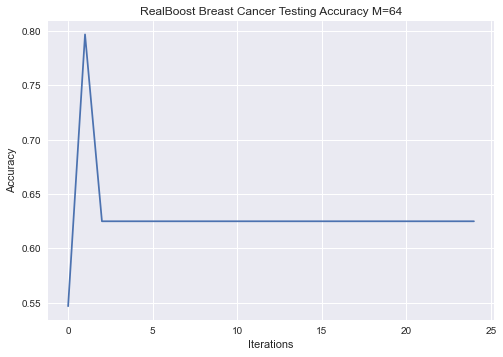

In [71]:
plot_fn(test_acc, 25, 64, ds = 'Breast Cancer', Algo= 'RealBoost', train_test = 'Testing')

y_mod [ 1  1 -1 -1  1 -1 -1  1  1  1 -1  1  1  1 -1 -1 -1  1  1  1 -1  1  1  1
  1  1 -1  1 -1  1 -1  1 -1  1  1  1 -1  1  1 -1 -1  1  1  1  1  1 -1  1
  1 -1 -1  1  1 -1  1  1 -1 -1  1  1  1  1 -1  1]
-----------------------ITERATION 1 -------------------------
 
Weak Hypothesis :  [0 1 1 1 1 1 1 0 2 0 1 2 1 0 1 1 1 1 2 1 1 0 2 0 0 0 2 0 1 0 1 0 1 2 1 0 1
 0 1 1 1 0 2 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 2]
 
Zt value :  0.6690878149589835
 
Beta values at iteration :  [8.576084727022206, -0.1592268601047221, 0.9729548002420426]
 
Beta values for each sample at iteration :  [8.576084727022206, -0.1592268601047221, -0.1592268601047221, -0.1592268601047221, -0.1592268601047221, -0.1592268601047221, -0.1592268601047221, 8.576084727022206, 0.9729548002420426, 8.576084727022206, -0.1592268601047221, 0.9729548002420426, -0.1592268601047221, 8.576084727022206, -0.1592268601047221, -0.1592268601047221, -0.1592268601047221, -0.1592268601047221, 0.9729548002420426, -0.1592268601047221, -0.15

Weak Hypothesis :  [0 2 1 1 2 1 1 0 0 0 1 0 2 0 1 1 2 0 0 2 1 0 0 0 0 0 0 0 1 0 1 0 1 0 2 0 2
 0 1 1 1 0 0 2 2 0 1 0 2 1 2 0 2 1 0 2 1 1 2 2 0 0 2 0]
 
Zt value :  1.0
 
Beta values at iteration :  [0.0, 0.0, 0.0]
 
Beta values for each sample at iteration :  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 
Strong Hypothesis :  [1, -1, -1, -1, -1, -1, -1, 1, 1, 1, -1, 1, 1, 1, -1, -1, -1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, -1, 1, 1, 1, 1, 1, -1, -1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, 1, 1, -1, 1]
 
Instantaneous Accuracy :  0.875
 
-----------------------ITERATION 17 -------------------------
 
Weak Hypothesis :  [0 2 1 1 2 1 1 0 0 0 1 0 2 0 1 1 2 0 0 2 1 0 0 0 0 0 0 0 1 

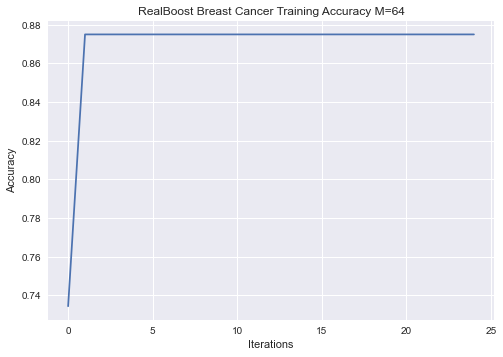

In [72]:
Dt, beta_jt, accuracies64bc, classifiers, Zt = realboost(X, y, T=25 ,C=3)
plot_fn(accuracies64bc, 25, 64, ds = 'Breast Cancer', Algo= 'RealBoost', train_test = 'Training')

[1 1 1 1 2 2 2 1 2 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 1 1 0 2 1 1 0 1 1 0 1 0
 1 1 1 1 0 1 1 1 1 0 1 2 1 1 1 1 0 2 1 1 1 1 1 2 1 0 1]
[0 0 2 2 1 1 1 0 1 2 0 2 2 0 1 0 1 0 2 2 1 2 1 2 1 2 0 1 1 2 0 1 2 2 1 0 1
 2 2 2 2 1 2 0 0 2 1 0 1 2 2 0 2 1 1 2 2 0 2 2 1 2 1 0]
[1 2 0 0 1 1 1 2 1 2 2 2 0 2 1 2 1 2 0 2 1 0 1 0 1 0 2 1 1 0 2 1 0 0 1 2 1
 0 0 0 2 1 2 2 2 0 1 1 1 0 0 1 2 1 1 2 0 1 0 0 1 0 1 1]
[0 2 1 1 0 0 0 2 0 2 2 2 1 2 0 2 0 2 1 2 0 1 0 1 0 1 2 0 0 1 2 0 1 1 0 2 0
 1 1 1 2 0 2 2 2 1 0 0 0 1 1 0 2 0 0 2 1 0 1 1 0 1 0 0]
[0 2 1 1 0 0 0 2 0 2 2 2 1 2 0 2 0 2 1 2 0 1 0 1 0 1 2 0 0 1 2 0 1 1 0 2 0
 1 1 1 2 0 2 2 2 1 0 0 0 1 1 0 2 0 0 2 1 0 1 1 0 1 0 0]
[0 2 1 1 0 0 0 2 0 2 2 2 1 2 0 2 0 2 1 2 0 1 0 1 0 1 2 0 0 1 2 0 1 1 0 2 0
 1 1 1 2 0 2 2 2 1 0 0 0 1 1 0 2 0 0 2 1 0 1 1 0 1 0 0]
[0 2 1 1 0 0 0 2 0 2 2 2 1 2 0 2 0 2 1 2 0 1 0 1 0 1 2 0 0 1 2 0 1 1 0 2 0
 1 1 1 2 0 2 2 2 1 0 0 0 1 1 0 2 0 0 2 1 0 1 1 0 1 0 0]
[0 2 1 1 0 0 0 2 0 2 2 2 1 2 0 2 0 2 1 2 0 1 0 1 0 1 2 0 0 1 2 0 1 1 0 2 0
 1 1 1 2

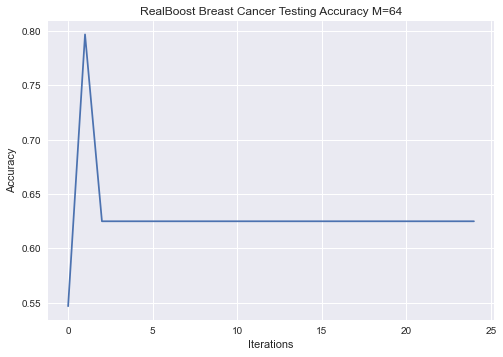

In [73]:
beta, test_acc64bc = testing(classifiers, beta_jt, X_test, y_test, 25, 4)
plot_fn(test_acc64bc, 25, 64, ds = 'Breast Cancer', Algo= 'RealBoost', train_test = 'Testing')

## M=32

In [74]:
X = np.array([[-0.52961818],
       [-0.73694129],
       [-0.98076452],
       [ 0.30469623],
       [-0.78349866],
       [-0.48788974],
       [-0.79870995],
       [ 0.25658932],
       [-0.70611322],
       [-0.74200188],
       [-0.7363877 ],
       [ 0.31199637],
       [-0.97364873],
       [ 0.71250752],
       [-0.55861402],
       [-0.63612516],
       [-0.90847131],
       [-0.54241534],
       [-0.21227206],
       [-0.49821623],
       [-0.7787262 ],
       [-0.69581626],
       [-0.77763277],
       [ 0.38337651],
       [-0.02174895],
       [-1.        ],
       [-0.63179088],
       [-0.9240283 ],
       [-0.83105823],
       [-0.61640269],
       [-0.95954346],
       [-0.81083621]])
y = np.array([1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1])

X_test = np.array([[-0.40839483],
       [-0.3025159 ],
       [-0.56281703],
       [ 1.        ],
       [-0.51608625],
       [-0.30182866],
       [-0.89821949],
       [-0.3258409 ],
       [ 0.24403701],
       [-0.08547389],
       [-0.81397378],
       [-0.52275241],
       [-0.84506346],
       [ 0.06944435],
       [ 0.12100471],
       [-0.82295834],
       [-0.56187142],
       [-0.47338434],
       [ 0.27271194],
       [-0.40050862],
       [-0.44610167],
       [-0.69609962],
       [-0.82142116],
       [-0.79394096],
       [-0.73949103],
       [-0.27940424],
       [ 0.80421303],
       [-0.32988797],
       [-0.78661245],
       [-0.75657348],
       [-0.77425805],
       [-0.89459281]])
y_test = np.array([1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1])


In [75]:
Dt, beta_jt, accuracies, classifiers, Zt = realboost(X, y, T=25 ,C=3)

y_mod [ 1  1  1 -1  1  1 -1 -1  1  1  1 -1  1 -1 -1  1  1  1 -1 -1  1  1  1 -1
 -1  1  1  1  1  1  1  1]
-----------------------ITERATION 1 -------------------------
 
Weak Hypothesis :  [0 2 1 0 1 0 1 0 2 2 2 0 1 0 0 0 1 0 0 0 1 2 1 0 0 1 0 1 1 0 1 1]
 
Zt value :  0.666647489706866
 
Beta values at iteration :  [-0.20273254516519368, 1.1989474909446651, 8.282191408793368]
 
Beta values for each sample at iteration :  [-0.20273254516519368, 8.282191408793368, 1.1989474909446651, -0.20273254516519368, 1.1989474909446651, -0.20273254516519368, 1.1989474909446651, -0.20273254516519368, 8.282191408793368, 8.282191408793368, 8.282191408793368, -0.20273254516519368, 1.1989474909446651, -0.20273254516519368, -0.20273254516519368, -0.20273254516519368, 1.1989474909446651, -0.20273254516519368, -0.20273254516519368, -0.20273254516519368, 1.1989474909446651, 8.282191408793368, 1.1989474909446651, -0.20273254516519368, -0.20273254516519368, 1.1989474909446651, -0.20273254516519368, 1.19894749094

Weak Hypothesis :  [2 1 1 0 1 0 1 0 1 1 1 0 1 0 2 2 1 2 0 0 1 1 1 0 0 1 2 1 1 2 1 1]
 
Zt value :  1.0
 
Beta values at iteration :  [-5.551115123125783e-17, -5.551115123125783e-17, 0.0]
 
Beta values for each sample at iteration :  [0.0, -5.551115123125783e-17, -5.551115123125783e-17, -5.551115123125783e-17, -5.551115123125783e-17, -5.551115123125783e-17, -5.551115123125783e-17, -5.551115123125783e-17, -5.551115123125783e-17, -5.551115123125783e-17, -5.551115123125783e-17, -5.551115123125783e-17, -5.551115123125783e-17, -5.551115123125783e-17, 0.0, 0.0, -5.551115123125783e-17, 0.0, -5.551115123125783e-17, -5.551115123125783e-17, -5.551115123125783e-17, -5.551115123125783e-17, -5.551115123125783e-17, -5.551115123125783e-17, -5.551115123125783e-17, -5.551115123125783e-17, 0.0, -5.551115123125783e-17, -5.551115123125783e-17, 0.0, -5.551115123125783e-17, -5.551115123125783e-17]
 
Strong Hypothesis :  [1, 1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, -1, -1, 1, 1, 1, -1, -1, 1, 1

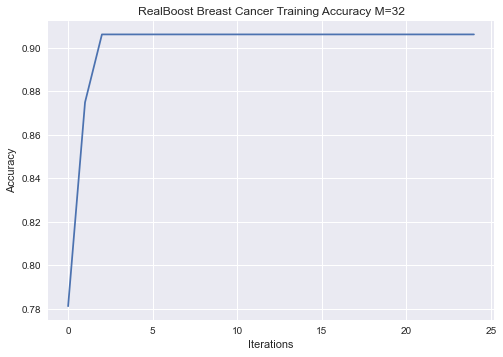

In [76]:
plot_fn(accuracies, 25, 32, ds = 'Breast Cancer', Algo= 'RealBoost', train_test = 'Training')

In [77]:
beta, test_acc = testing(classifiers, beta_jt, X_test, y_test, 25, 4)

[0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 2 1 1 2 0 0 0 1 2 2 1]
[0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 2 1 1 1 0 0 0 1 1 1 1]
[1 1 2 1 2 1 0 1 1 1 0 2 0 1 1 0 2 1 1 1 1 0 0 0 0 1 1 1 0 0 0 0]
[0 0 2 0 0 0 1 0 0 0 1 2 1 0 0 1 2 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1]
[0 0 2 0 0 0 1 0 0 0 1 2 1 0 0 1 2 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1]
[0 0 2 0 0 0 1 0 0 0 1 2 1 0 0 1 2 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1]
[0 0 2 0 0 0 1 0 0 0 1 2 1 0 0 1 2 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1]
[0 0 2 0 0 0 1 0 0 0 1 2 1 0 0 1 2 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1]
[0 0 2 0 0 0 1 0 0 0 1 2 1 0 0 1 2 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1]
[0 0 2 0 0 0 1 0 0 0 1 2 1 0 0 1 2 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1]
[0 0 2 0 0 0 1 0 0 0 1 2 1 0 0 1 2 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1]
[0 0 2 0 0 0 1 0 0 0 1 2 1 0 0 1 2 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1]
[0 0 2 0 0 0 1 0 0 0 1 2 1 0 0 1 2 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1]
[0 0 2 0 0 0 1 0 0 0 1 2 1 0 0 1 2 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1]
[0 0 2 0 0 0 1 0 0 0 1 2 1 0 0 1 2 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1]
[0 0 2 0 0

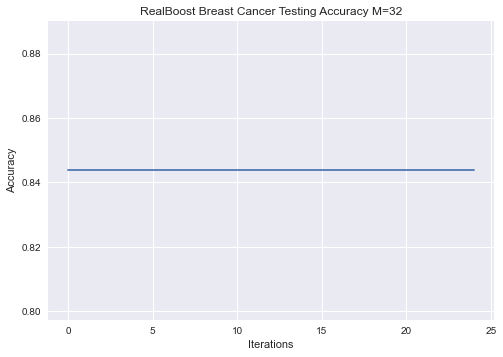

In [78]:
plot_fn(test_acc, 25, 32, ds = 'Breast Cancer', Algo= 'RealBoost', train_test = 'Testing')

y_mod [ 1  1  1 -1  1  1 -1 -1  1  1  1 -1  1 -1 -1  1  1  1 -1 -1  1  1  1 -1
 -1  1  1  1  1  1  1  1]
-----------------------ITERATION 1 -------------------------
 
Weak Hypothesis :  [0 2 1 0 1 0 1 0 2 2 2 0 1 0 0 0 1 0 0 0 1 2 1 0 0 1 0 1 1 0 1 1]
 
Zt value :  0.666647489706866
 
Beta values at iteration :  [-0.20273254516519368, 1.1989474909446651, 8.282191408793368]
 
Beta values for each sample at iteration :  [-0.20273254516519368, 8.282191408793368, 1.1989474909446651, -0.20273254516519368, 1.1989474909446651, -0.20273254516519368, 1.1989474909446651, -0.20273254516519368, 8.282191408793368, 8.282191408793368, 8.282191408793368, -0.20273254516519368, 1.1989474909446651, -0.20273254516519368, -0.20273254516519368, -0.20273254516519368, 1.1989474909446651, -0.20273254516519368, -0.20273254516519368, -0.20273254516519368, 1.1989474909446651, 8.282191408793368, 1.1989474909446651, -0.20273254516519368, -0.20273254516519368, 1.1989474909446651, -0.20273254516519368, 1.19894749094

Weak Hypothesis :  [2 1 1 0 1 0 1 0 1 1 1 0 1 0 2 2 1 2 0 0 1 1 1 0 0 1 2 1 1 2 1 1]
 
Zt value :  1.0
 
Beta values at iteration :  [-5.551115123125783e-17, -5.551115123125783e-17, 0.0]
 
Beta values for each sample at iteration :  [0.0, -5.551115123125783e-17, -5.551115123125783e-17, -5.551115123125783e-17, -5.551115123125783e-17, -5.551115123125783e-17, -5.551115123125783e-17, -5.551115123125783e-17, -5.551115123125783e-17, -5.551115123125783e-17, -5.551115123125783e-17, -5.551115123125783e-17, -5.551115123125783e-17, -5.551115123125783e-17, 0.0, 0.0, -5.551115123125783e-17, 0.0, -5.551115123125783e-17, -5.551115123125783e-17, -5.551115123125783e-17, -5.551115123125783e-17, -5.551115123125783e-17, -5.551115123125783e-17, -5.551115123125783e-17, -5.551115123125783e-17, 0.0, -5.551115123125783e-17, -5.551115123125783e-17, 0.0, -5.551115123125783e-17, -5.551115123125783e-17]
 
Strong Hypothesis :  [1, 1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, -1, -1, 1, 1, 1, -1, -1, 1, 1

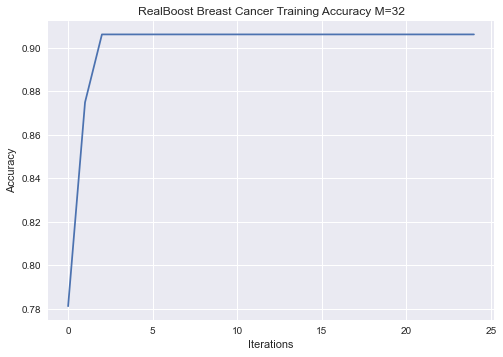

In [79]:
Dt, beta_jt, accuracies32bc, classifiers, Zt = realboost(X, y, T=25 ,C=3)
plot_fn(accuracies32bc, 25, 32, ds = 'Breast Cancer', Algo= 'RealBoost', train_test = 'Training')

[0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 2 1 1 2 0 0 0 1 2 2 1]
[0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 2 1 1 1 0 0 0 1 1 1 1]
[1 1 2 1 2 1 0 1 1 1 0 2 0 1 1 0 2 1 1 1 1 0 0 0 0 1 1 1 0 0 0 0]
[0 0 2 0 0 0 1 0 0 0 1 2 1 0 0 1 2 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1]
[0 0 2 0 0 0 1 0 0 0 1 2 1 0 0 1 2 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1]
[0 0 2 0 0 0 1 0 0 0 1 2 1 0 0 1 2 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1]
[0 0 2 0 0 0 1 0 0 0 1 2 1 0 0 1 2 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1]
[0 0 2 0 0 0 1 0 0 0 1 2 1 0 0 1 2 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1]
[0 0 2 0 0 0 1 0 0 0 1 2 1 0 0 1 2 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1]
[0 0 2 0 0 0 1 0 0 0 1 2 1 0 0 1 2 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1]
[0 0 2 0 0 0 1 0 0 0 1 2 1 0 0 1 2 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1]
[0 0 2 0 0 0 1 0 0 0 1 2 1 0 0 1 2 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1]
[0 0 2 0 0 0 1 0 0 0 1 2 1 0 0 1 2 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1]
[0 0 2 0 0 0 1 0 0 0 1 2 1 0 0 1 2 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1]
[0 0 2 0 0 0 1 0 0 0 1 2 1 0 0 1 2 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1]
[0 0 2 0 0

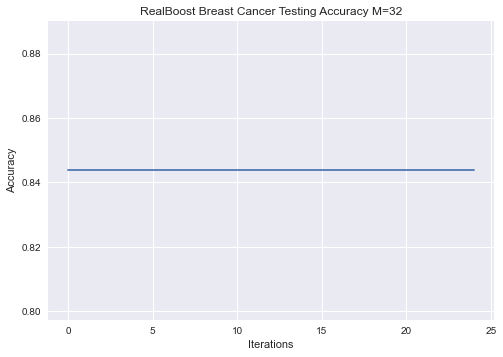

In [80]:
beta, test_acc32bc = testing(classifiers, beta_jt, X_test, y_test, 25, 4)
plot_fn(test_acc32bc, 25, 32, ds = 'Breast Cancer', Algo= 'RealBoost', train_test = 'Testing')

## M = 16

In [81]:
X = np.array([[-0.76764442],
       [-0.61776561],
       [-0.76501246],
       [ 0.13807384],
       [-0.61909054],
       [ 0.36288268],
       [-1.        ],
       [-0.61300765],
       [-0.33114908],
       [-0.65033625],
       [-0.79890335],
       [-0.56009028],
       [ 0.10323057],
       [-0.52076065],
       [-0.89158817],
       [-0.73638509]])

y = np.array([1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1]
)

X_test = np.array([[-0.95872091],
       [-0.92576013],
       [-0.73496398],
       [-0.79805629],
       [-0.57538087],
       [-0.49002715],
       [ 0.72440735],
       [ 1.        ],
       [-0.56658794],
       [-0.34205072],
       [-0.83562247],
       [-0.68286875],
       [-0.74067301],
       [-0.74345532],
       [-0.9301953 ],
       [-0.81564803]])

y_test = np.array([1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1])



In [82]:
Dt, beta_jt, accuracies, classifiers, Zt = realboost(X, y, T=25 ,C=3)

y_mod [ 1 -1  1 -1 -1 -1  1 -1 -1  1  1  1 -1 -1  1  1]
-----------------------ITERATION 1 -------------------------
 
Weak Hypothesis :  [1 1 1 0 1 0 2 1 1 1 1 1 0 1 2 1]
 
Zt value :  0.6848105301882531
 
Beta values at iteration :  [-8.373352181857014, 0.09116077573031077, 8.170619641136263]
 
Beta values for each sample at iteration :  [0.09116077573031077, 0.09116077573031077, 0.09116077573031077, -8.373352181857014, 0.09116077573031077, -8.373352181857014, 8.170619641136263, 0.09116077573031077, 0.09116077573031077, 0.09116077573031077, 0.09116077573031077, 0.09116077573031077, -8.373352181857014, 0.09116077573031077, 8.170619641136263, 0.09116077573031077]
 
Strong Hypothesis :  [1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1]
 
Instantaneous Accuracy :  0.6875
 
-----------------------ITERATION 2 -------------------------
 
Weak Hypothesis :  [0 0 0 2 0 2 0 0 2 0 0 1 2 1 0 0]
 
Zt value :  0.8895836703214833
 
Beta values at iteration :  [0.16431399537467126, -0.091160765728

Weak Hypothesis :  [2 0 2 0 0 0 2 0 0 1 2 0 0 0 2 2]
 
Zt value :  0.1972435633625468
 
Beta values at iteration :  [-1.5829783866096412, 8.469538587762221, 8.48037022512368]
 
Beta values for each sample at iteration :  [8.48037022512368, -1.5829783866096412, 8.48037022512368, -1.5829783866096412, -1.5829783866096412, -1.5829783866096412, 8.48037022512368, -1.5829783866096412, -1.5829783866096412, 8.469538587762221, 8.48037022512368, -1.5829783866096412, -1.5829783866096412, -1.5829783866096412, 8.48037022512368, 8.48037022512368]
 
Strong Hypothesis :  [1, -1, 1, -1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, 1]
 
Instantaneous Accuracy :  1.0
 
-----------------------ITERATION 21 -------------------------
 
Weak Hypothesis :  [2 2 2 0 2 0 2 2 0 2 2 1 0 0 2 2]
 
Zt value :  0.030669139835700014
 
Beta values at iteration :  [-7.280259728098804, 8.863280282266627, -3.446011574887642]
 
Beta values for each sample at iteration :  [-3.446011574887642, -3.446011574887642, -3.446011574887642,

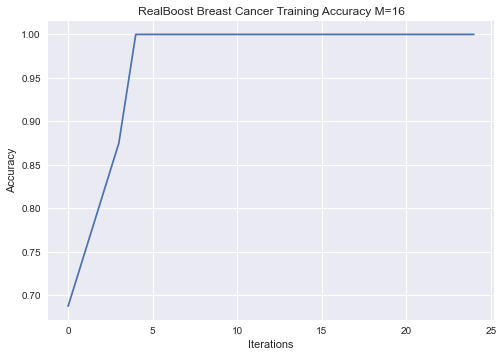

In [83]:
plot_fn(accuracies, 25, 16, ds = 'Breast Cancer', Algo= 'RealBoost', train_test = 'Training')

In [84]:
beta, test_acc = testing(classifiers, beta_jt, X_test, y_test, 25, 4)

[2 2 1 1 1 1 0 0 1 1 1 1 1 1 2 1]
[0 0 0 0 0 1 2 2 1 2 0 0 0 0 0 0]
[2 2 2 2 0 1 1 1 1 1 2 2 2 2 2 2]
[1 1 1 1 2 0 0 0 2 0 1 1 1 1 1 1]
[2 2 2 2 0 0 0 0 0 0 2 1 2 2 2 2]
[2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2]
[2 2 2 2 0 1 1 1 0 1 2 2 2 2 2 2]
[2 2 2 2 0 0 0 0 0 0 2 1 2 2 2 2]
[2 2 2 2 1 0 0 0 1 0 2 2 2 2 2 2]
[2 2 2 2 0 0 0 0 0 0 2 1 2 2 2 2]
[1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1]
[2 2 2 2 1 0 0 0 1 0 2 2 2 2 2 2]
[2 2 2 2 0 0 0 0 0 0 2 1 2 2 2 2]
[2 2 2 2 1 0 0 0 1 0 2 2 2 2 2 2]
[2 2 2 2 0 0 0 0 0 0 2 1 2 2 2 2]
[2 2 2 2 1 0 0 0 1 0 2 2 2 2 2 2]
[2 2 2 2 0 0 0 0 0 0 2 1 2 2 2 2]
[2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2]
[2 2 2 2 1 0 0 0 1 0 2 2 2 2 2 2]
[2 2 2 2 0 0 0 0 0 0 2 1 2 2 2 2]
[2 2 2 2 1 0 0 0 1 0 2 2 2 2 2 2]
[2 2 2 2 0 0 0 0 0 0 2 1 2 2 2 2]
[1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1]
[2 2 2 2 1 0 0 0 1 0 2 2 2 2 2 2]
[2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2]


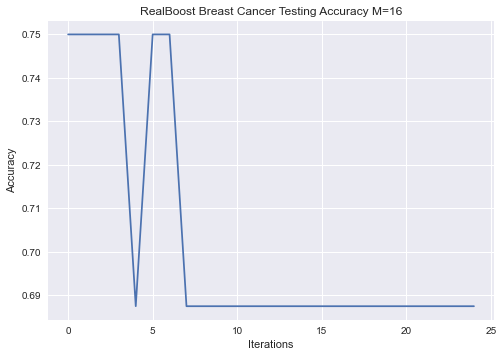

In [85]:
plot_fn(test_acc, 25, 16, ds = 'Breast Cancer', Algo= 'RealBoost', train_test = 'Testing')

y_mod [ 1 -1  1 -1 -1 -1  1 -1 -1  1  1  1 -1 -1  1  1]
-----------------------ITERATION 1 -------------------------
 
Weak Hypothesis :  [1 1 1 0 1 0 2 1 1 1 1 1 0 1 2 1]
 
Zt value :  0.6848105301882531
 
Beta values at iteration :  [-8.373352181857014, 0.09116077573031077, 8.170619641136263]
 
Beta values for each sample at iteration :  [0.09116077573031077, 0.09116077573031077, 0.09116077573031077, -8.373352181857014, 0.09116077573031077, -8.373352181857014, 8.170619641136263, 0.09116077573031077, 0.09116077573031077, 0.09116077573031077, 0.09116077573031077, 0.09116077573031077, -8.373352181857014, 0.09116077573031077, 8.170619641136263, 0.09116077573031077]
 
Strong Hypothesis :  [1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1]
 
Instantaneous Accuracy :  0.6875
 
-----------------------ITERATION 2 -------------------------
 
Weak Hypothesis :  [0 0 0 2 0 2 0 0 2 0 0 1 2 1 0 0]
 
Zt value :  0.8895836703214833
 
Beta values at iteration :  [0.16431399537467126, -0.091160765728

Weak Hypothesis :  [2 2 2 0 2 0 2 2 0 2 2 1 0 0 2 2]
 
Zt value :  0.0034708194223650258
 
Beta values at iteration :  [-8.856816868565486, 8.856901658389129, -1.3928968667558161]
 
Beta values for each sample at iteration :  [-1.3928968667558161, -1.3928968667558161, -1.3928968667558161, -8.856816868565486, -1.3928968667558161, -8.856816868565486, -1.3928968667558161, -1.3928968667558161, -8.856816868565486, -1.3928968667558161, -1.3928968667558161, 8.856901658389129, -8.856816868565486, -8.856816868565486, -1.3928968667558161, -1.3928968667558161]
 
Strong Hypothesis :  [1, -1, 1, -1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, 1]
 
Instantaneous Accuracy :  1.0
 
-----------------------ITERATION 20 -------------------------
 
Weak Hypothesis :  [2 0 2 0 0 0 2 0 0 1 2 0 0 0 2 2]
 
Zt value :  0.1972435633625468
 
Beta values at iteration :  [-1.5829783866096412, 8.469538587762221, 8.48037022512368]
 
Beta values for each sample at iteration :  [8.48037022512368, -1.5829783866096412, 8.480

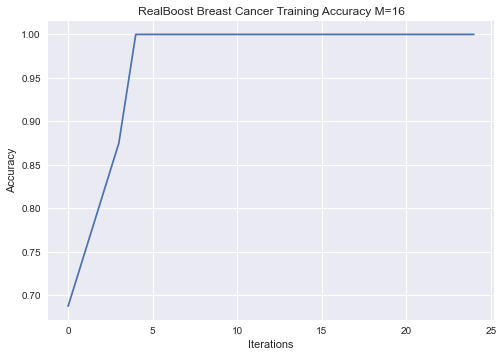

In [86]:
Dt, beta_jt, accuracies16bc, classifiers, Zt = realboost(X, y, T=25 ,C=3)
plot_fn(accuracies16bc, 25, 16, ds = 'Breast Cancer', Algo= 'RealBoost', train_test = 'Training')

[2 2 1 1 1 1 0 0 1 1 1 1 1 1 2 1]
[0 0 0 0 0 1 2 2 1 2 0 0 0 0 0 0]
[2 2 2 2 0 1 1 1 1 1 2 2 2 2 2 2]
[1 1 1 1 2 0 0 0 2 0 1 1 1 1 1 1]
[2 2 2 2 0 0 0 0 0 0 2 1 2 2 2 2]
[2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2]
[2 2 2 2 0 1 1 1 0 1 2 2 2 2 2 2]
[2 2 2 2 0 0 0 0 0 0 2 1 2 2 2 2]
[2 2 2 2 1 0 0 0 1 0 2 2 2 2 2 2]
[2 2 2 2 0 0 0 0 0 0 2 1 2 2 2 2]
[1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1]
[2 2 2 2 1 0 0 0 1 0 2 2 2 2 2 2]
[2 2 2 2 0 0 0 0 0 0 2 1 2 2 2 2]
[2 2 2 2 1 0 0 0 1 0 2 2 2 2 2 2]
[2 2 2 2 0 0 0 0 0 0 2 1 2 2 2 2]
[2 2 2 2 1 0 0 0 1 0 2 2 2 2 2 2]
[2 2 2 2 0 0 0 0 0 0 2 1 2 2 2 2]
[2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2]
[2 2 2 2 1 0 0 0 1 0 2 2 2 2 2 2]
[2 2 2 2 0 0 0 0 0 0 2 1 2 2 2 2]
[2 2 2 2 1 0 0 0 1 0 2 2 2 2 2 2]
[2 2 2 2 0 0 0 0 0 0 2 1 2 2 2 2]
[1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1]
[2 2 2 2 1 0 0 0 1 0 2 2 2 2 2 2]
[2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2]


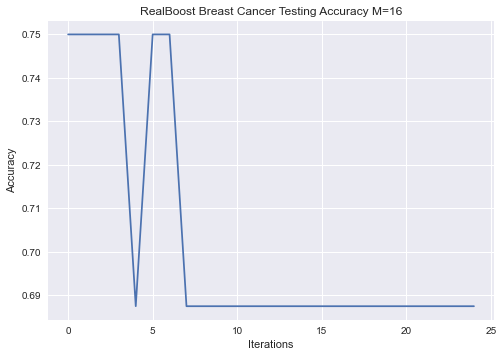

In [87]:
beta, test_acc16bc = testing(classifiers, beta_jt, X_test, y_test, 25, 4)
plot_fn(test_acc16bc, 25, 16, ds = 'Breast Cancer', Algo= 'RealBoost', train_test = 'Testing')

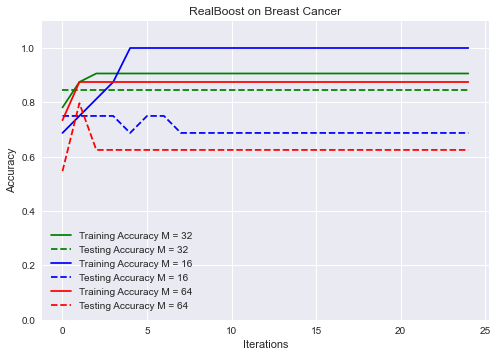

In [88]:
plt.style.use('seaborn')
plt.plot(list(range(25)), accuracies32bc, "g-", label = "Training Accuracy M = 32")
plt.plot(list(range(25)), test_acc32bc, "g--", label = "Testing Accuracy M = 32")

plt.plot(list(range(25)), accuracies16bc, "b-", label = "Training Accuracy M = 16")
plt.plot(list(range(25)), test_acc16bc, "b--", label = "Testing Accuracy M = 16")

plt.plot(list(range(25)), accuracies64bc, "r-", label = "Training Accuracy M = 64")
plt.plot(list(range(25)), test_acc64bc, "r--", label = "Testing Accuracy M = 64")

# plt.plot([], [], 'k-', label="Training Accuracy")
# plt.plot([], [], 'k--', label="Testing Accuracy")

plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.title("RealBoost on Breast Cancer")
plt.ylim([0,1.1])

plt.show()

# MNIST

## M = 64

In [89]:
X64 = np.array([[-0.80589907, -0.59042291, -0.05324325,  0.10774176, -0.04505932],
       [ 0.06256734, -0.37244006,  0.0939138 , -0.2033949 , -0.94811908],
       [-0.84338317, -0.6326198 , -0.43462352,  0.24523402, -0.52480534],
       [ 0.13286258,  0.37155658, -0.87001548,  0.70985865,  0.6677744 ],
       [-0.75234354, -0.21787303,  0.12046462, -0.59419401, -0.56680623],
       [ 0.28907508,  0.9888873 , -0.36947398, -0.3852527 ,  0.12494092],
       [-0.94193876, -0.07222975, -0.51910519, -0.34613681, -0.50121778],
       [-0.63461962, -0.66262997, -0.01359157, -0.20885209,  0.32881507],
       [ 0.26177535,  0.73210506,  0.14869942, -0.08739544, -0.41974897],
       [-0.87627756, -0.05459176, -0.79168413, -0.44217547, -0.76591014],
       [-0.31582251, -0.65735629,  0.80118443, -0.14383058,  0.05621122],
       [-0.56914731,  0.02827011, -0.70470652, -0.62345748,  0.07444681],
       [ 0.35079842,  0.84817601, -0.38494076, -0.29560828, -0.07015869],
       [ 0.60451149, -0.77078297, -0.00920281,  0.17409424, -0.29259797],
       [ 0.23017942,  0.13002239,  0.1935483 ,  0.2473952 , -0.39510758],
       [ 0.94377071, -0.63914724, -0.44823675, -0.35877896, -0.2279727 ],
       [-0.41203935, -0.63002251, -0.25803975, -0.13481458,  1.        ],
       [-0.84141311, -0.37295448,  0.23098801, -0.09279513, -0.30896296],
       [-0.63473418, -0.64862994, -0.34478505,  0.30493717, -0.31294345],
       [ 0.54624343, -0.05513775, -0.37989372,  0.44105009, -0.54167204],
       [ 0.41786759,  0.90609941, -0.47142637, -0.12383133,  0.07869459],
       [ 0.83676509, -0.60596934, -0.56257506, -1.        , -0.12157583],
       [ 0.09787885,  0.41570962,  0.05702348,  0.7133461 , -0.32991341],
       [ 0.56101992,  0.62038019, -0.28584764,  0.05462626, -0.96150592],
       [ 0.49179288, -0.1536601 , -0.20058942,  1.        , -0.23212819],
       [ 0.42401093, -0.29381199,  0.02061487,  0.68741985, -0.63409955],
       [-0.67235847, -0.68699306, -1.        ,  0.12998496, -0.64246139],
       [ 0.68981195, -0.7822776 , -0.45056316,  0.17824033, -0.28578779],
       [-0.8566584 , -0.04364493, -0.26908778, -0.35775043, -0.87088248],
       [-0.09183266,  0.77482135,  0.05847358, -0.03713341, -0.63098033],
       [ 0.82501212, -0.80820505, -0.18331782,  0.43321777, -0.49106175],
       [ 0.39893683,  0.94363918, -0.45686527,  0.24407125, -0.05909602],
       [ 0.69339013, -0.91467442, -0.23083126, -0.61828926, -0.31150299],
       [ 0.1360446 ,  0.4176652 ,  0.16521813,  0.28788609, -0.51930635],
       [ 0.44215386,  0.98543464, -0.37949666, -0.41211015,  0.05908244],
       [ 0.24224883,  0.81801481, -0.1429181 , -0.66253758, -0.39744601],
       [ 0.78826496, -0.72251302, -0.07685949, -0.01906448, -0.81606224],
       [ 0.64234617, -0.90884405, -0.01065299, -0.14171669, -0.5395039 ],
       [ 0.78331642, -0.79602718, -0.29497289, -0.38296365, -0.25876049],
       [ 0.58122718, -0.50820971, -0.39361292, -0.24785874,  0.49198399],
       [ 0.82427747, -0.77037464, -0.33859388,  0.59875024, -0.54046202],
       [-0.15491631,  0.42594546,  0.28120175, -0.12650848, -0.39095192],
       [-0.41265761, -0.778387  ,  0.38536974, -0.56097033,  0.27519472],
       [ 0.81281306, -0.82835321, -0.43001264,  0.54553452, -0.37301733],
       [-0.79622109, -0.04406497, -0.92528577, -0.37335828, -0.85511111],
       [ 0.12804201,  0.86948804, -0.01275777,  0.10466105,  0.11716134],
       [ 0.6583697 , -0.90448218, -0.07580081, -0.24559957, -0.43876332],
       [ 0.16191584,  0.4965871 ,  0.0479586 ,  0.21035375,  0.15673964],
       [ 0.30857441,  0.23363984,  0.06129492,  0.15414908,  0.07127983],
       [ 0.74245608, -0.6790161 , -0.23658274, -0.83579257, -0.14014044],
       [-0.15075894, -0.46560074,  0.50815128, -0.2837593 , -0.29533477],
       [-0.34931682,  0.03215297,  0.8454444 , -0.01232477, -0.14328294],
       [-0.85718266, -0.35816008, -0.53285026,  0.14980072, -0.38222436],
       [ 0.25723461,  0.63688708, -0.28527578, -0.29904661, -0.44305987],
       [ 0.17414132,  0.58749761,  0.09322319, -0.53893208, -0.92804504],
       [-0.39998583, -0.20541629,  0.78988065,  0.12372396, -0.14401889],
       [-0.66096707, -0.60768684, -0.08385178,  0.40744248, -0.24225684],
       [-0.87921722, -0.71534639, -0.43692453,  0.19842837,  0.1174938 ],
       [-0.81297545, -0.46532236, -0.31752754, -0.17918259,  0.04073442],
       [-0.91092209, -0.07973995, -0.33283798,  0.32994368, -0.60723175],
       [ 0.89593489, -1.        , -0.18398778, -0.54238746, -0.40547704],
       [-0.94852912,  0.07138546,  0.01882709, -0.01040221, -0.87775444],
       [-0.81245264, -0.36296099, -0.96669405,  0.22999089,  0.05613461],
       [-0.33243217, -0.33300052,  1.        , -0.05262967, -0.07337535]])

X_test64 = np.array([[-0.68707325, -0.50735238, -0.20700664, -0.62336223,  0.39806279],
       [ 0.46234745,  0.81775949, -0.44946658,  0.1140975 , -0.17951633],
       [ 0.61516826,  0.29117629, -0.20364858,  0.46090612,  0.00305875],
       [-0.50432232, -0.64050608,  0.13880843, -0.42755397,  0.47996396],
       [-0.58363044, -0.59302057, -0.36068798, -0.20546695,  0.42447254],
       [-0.77781706, -0.52822617,  0.1248982 , -0.39869912, -0.65804837],
       [-0.31182115, -0.16652907, -0.02315063,  0.05638778, -0.47035166],
       [-0.35714232, -0.56180839,  0.02707521, -0.3134225 ,  0.7454719 ],
       [ 0.40935228,  1.        , -0.52272328,  0.10199332,  0.13573632],
       [-0.5209226 , -0.19721416, -0.90344255, -0.43913667, -0.10011288],
       [-0.40235592, -0.6796702 , -0.49861898, -0.07365373,  0.85654452],
       [ 0.81742342, -0.54015171, -0.13383637, -0.1039951 , -0.93044641],
       [ 0.3254841 , -0.50934448,  0.04402021,  0.36110195, -0.37572541],
       [-0.09288116, -0.13640449,  0.05706831,  0.16841045, -0.95817001],
       [-0.90998517, -0.40430919, -0.86355457, -0.26217541, -0.064167  ],
       [-0.57775116, -0.76387782,  0.29964566, -0.30444234,  0.54161409],
       [ 0.21042602,  0.53453165,  0.05184494, -0.23258185, -0.75751172],
       [ 0.48320202,  0.85674321, -0.33808615, -0.17128284, -0.28369987],
       [-0.19770072, -0.68336291,  0.18640211, -0.35917056,  0.8291267 ],
       [ 0.65655214, -0.73443385, -0.42628468,  0.60888795,  0.01226754],
       [ 0.50016485,  0.0690652 , -0.45885945,  0.62442559,  0.06448148],
       [-0.38902654, -0.43851828,  0.66980889, -0.02364348,  0.01094794],
       [ 0.40796953, -0.85934891,  0.02097323, -0.25803196, -0.53040584],
       [-0.4956964 , -0.56031991,  0.74363441, -0.1163954 , -0.08862714],
       [-0.10882911,  0.64180596,  0.1375903 , -0.111592  , -0.30924287],
       [ 0.28332875,  0.79302765, -0.3118484 , -0.04220763, -0.12566824],
       [ 0.42676069, -0.61204992,  0.05231732, -0.25486205, -0.61785986],
       [ 0.60709358, -0.95289575, -0.18889892, -0.39078964, -0.212501  ],
       [-0.64455773, -0.20147303,  0.56736837, -0.29192325, -0.55664189],
       [ 0.45437401,  0.54042794, -0.13070526,  0.12284947, -0.55259124],
       [ 0.57638579, -0.67840819, -0.07071206, -0.21873946, -0.29933831],
       [-0.70554067, -0.51734514,  0.30348356, -0.5745156 , -0.12432887],
       [-0.51785336, -0.58458137,  0.53423814,  0.03205322, -0.05940223],
       [ 0.66912668, -0.78523877,  0.14110695, -0.00521186, -0.60630297],
       [-0.74108656, -0.13630257, -0.9809313 , -0.48456012, -0.29452577],
       [-0.64419453, -0.72115311, -0.14011673,  0.03085746, -0.41771499],
       [ 0.22878316, -0.07614892, -0.18493723,  0.4526321 , -0.1085523 ],
       [-0.8218347 , -0.28596485, -0.43286115, -0.48878151,  0.16100587],
       [ 0.53267724,  0.99697226, -0.51289751,  0.12752771, -0.36206251],
       [-0.46209981, -0.66716044, -0.10202221, -0.23609424,  0.47423212],
       [ 0.17014884,  0.40169187, -0.07279546,  0.04706547,  0.19721313],
       [ 0.59520936, -0.63509737, -0.39774277,  0.40608186, -0.057771  ],
       [-0.64006887, -0.33616701,  0.46128481, -0.0703224 , -0.05672336],
       [ 0.26505329, -0.21119132,  0.05232592,  0.21870707, -0.5844182 ],
       [ 0.25674746,  0.17546479,  0.12126193,  0.12813838, -0.9701474 ],
       [-0.46393382, -0.4577407 ,  0.69860785, -0.43353711, -0.15944243],
       [-0.58917778, -0.56371509,  0.41512294, -0.27969881, -0.02538025],
       [-0.66348932, -0.51538817,  0.25466218, -0.00358557, -0.35842899],
       [ 0.56951207, -0.68392313, -0.02628225,  0.17040521, -0.83197979],
       [-1.        , -0.32924987, -0.69087141, -0.44459176, -0.57811392],
       [ 1.        , -0.63579192, -0.49398102, -0.51258059, -0.30743351],
       [-0.83693098,  0.07785999, -0.41222783, -0.26083857, -0.66387623],
       [-0.05528876, -0.62425213,  0.25233409, -0.37310216,  0.73313602],
       [ 0.14568479,  0.43524995,  0.07727313,  0.0157491 , -0.53613886],
       [-0.02228015,  0.24813905,  0.03025536, -0.12589894, -0.97440804],
       [ 0.17895445,  0.64919227, -0.04496854, -0.23686312, -0.82210064],
       [-0.37993654, -0.45300412,  0.372467  , -0.02913794, -0.337318  ],
       [ 0.75550289, -0.85494843, -0.310949  , -0.81275764,  0.0746331 ],
       [ 0.38994431,  0.89259644, -0.24342355, -0.04604866, -0.03464256],
       [-0.73642587, -0.5752054 , -0.1700719 , -0.25048668,  0.33491302],
       [-0.73061136, -0.65033171, -0.55164925,  0.07918039,  0.44719878],
       [ 0.54081739,  0.17102128, -0.14932038,  0.52861686, -0.73708794],
       [ 0.46486667, -0.112343  ,  0.16271583, -0.00918502, -1.        ],
       [-0.74623427, -0.57101018,  0.00589433, -0.21381337,  0.34660433]])

y64 = [0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0]

y_test64 = [0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0]

X = X64
X_test = X_test64
y = y64
y_test = y_test64


In [90]:
Dt, beta_jt, accuracies, classifiers, Zt = realboost(X, y, T=25 ,C=3)

y_mod [-1  1 -1  1 -1  1 -1 -1  1 -1 -1 -1  1  1  1  1 -1 -1 -1  1  1  1  1  1
  1  1 -1  1 -1  1  1  1  1  1  1  1  1  1  1 -1  1  1 -1  1 -1  1  1  1
  1  1 -1 -1 -1  1  1 -1 -1 -1 -1 -1  1 -1 -1 -1]
-----------------------ITERATION 1 -------------------------
 
Weak Hypothesis :  [1 1 1 2 1 2 1 1 2 1 1 1 2 0 2 0 1 1 1 2 2 0 2 2 2 2 1 0 1 2 2 2 0 2 2 2 0
 0 0 0 2 2 1 2 1 2 0 2 2 0 1 1 1 2 2 1 1 1 1 1 0 1 1 1]
 
Zt value :  0.2631139736326867
 
Beta values at iteration :  [1.1989473454901958, -1.6290479613185356, 8.740336755530446]
 
Beta values for each sample at iteration :  [-1.6290479613185356, -1.6290479613185356, -1.6290479613185356, 8.740336755530446, -1.6290479613185356, 8.740336755530446, -1.6290479613185356, -1.6290479613185356, 8.740336755530446, -1.6290479613185356, -1.6290479613185356, -1.6290479613185356, 8.740336755530446, 1.1989473454901958, 8.740336755530446, 1.1989473454901958, -1.6290479613185356, -1.6290479613185356, -1.6290479613185356, 8.740336755530446, 8.740336

Weak Hypothesis :  [2 0 0 1 2 1 0 2 2 0 2 1 1 1 2 1 1 2 0 0 1 1 2 0 1 0 0 1 0 0 0 1 1 0 1 0 0
 0 1 1 0 2 2 1 0 2 0 2 2 1 2 2 0 0 0 2 2 2 2 0 1 0 1 2]
 
Zt value :  0.17056423920039052
 
Beta values at iteration :  [2.548305680653144, -4.165078973338087e-05, -4.768437144465387]
 
Beta values for each sample at iteration :  [-4.768437144465387, 2.548305680653144, 2.548305680653144, -4.165078973338087e-05, -4.768437144465387, -4.165078973338087e-05, 2.548305680653144, -4.768437144465387, -4.768437144465387, 2.548305680653144, -4.768437144465387, -4.165078973338087e-05, -4.165078973338087e-05, -4.165078973338087e-05, -4.768437144465387, -4.165078973338087e-05, -4.165078973338087e-05, -4.768437144465387, 2.548305680653144, 2.548305680653144, -4.165078973338087e-05, -4.165078973338087e-05, -4.768437144465387, 2.548305680653144, -4.165078973338087e-05, 2.548305680653144, 2.548305680653144, -4.165078973338087e-05, 2.548305680653144, 2.548305680653144, 2.548305680653144, -4.165078973338087e-05,

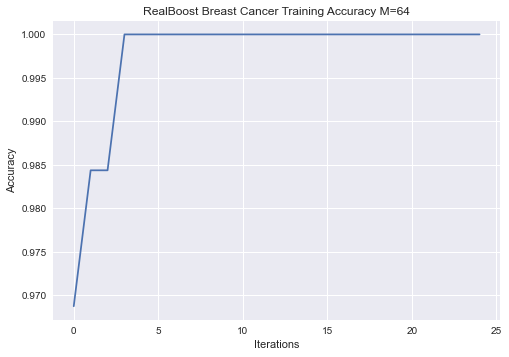

In [91]:
plot_fn(accuracies, 25, 64, ds = 'Breast Cancer', Algo= 'RealBoost', train_test = 'Training')

In [92]:
beta, test_acc = testing(classifiers, beta_jt, X_test, y_test, 25, 4)

[1 2 2 1 1 1 1 1 2 0 1 0 2 2 1 1 2 2 1 2 2 1 0 1 2 2 0 0 1 2 0 1 1 0 1 1 2
 1 2 1 2 2 1 2 2 1 1 1 2 1 0 1 1 2 2 2 1 0 2 1 1 2 2 1]
[1 1 1 1 1 2 2 1 1 1 1 0 2 2 2 1 2 2 1 1 1 2 0 2 2 1 0 0 2 2 0 2 2 0 2 2 1
 1 2 1 1 0 2 2 2 2 2 2 2 2 0 2 1 2 2 2 2 0 1 1 1 2 2 1]
[2 2 2 0 2 2 2 0 2 1 2 2 2 2 1 0 2 2 0 2 2 0 2 0 2 2 2 2 0 2 2 0 0 2 1 2 2
 1 2 2 2 2 0 2 2 0 0 2 2 1 2 1 0 2 2 2 2 2 2 2 2 2 2 2]
[1 0 0 1 1 2 0 1 0 2 1 0 0 0 1 1 0 0 1 1 1 1 0 1 2 0 0 0 2 0 0 2 1 0 2 1 1
 2 0 1 1 0 1 0 0 2 1 1 0 2 0 2 1 0 0 0 1 0 0 1 1 0 0 1]
[2 2 0 2 2 2 2 2 2 2 1 0 0 0 1 2 2 2 2 0 0 2 0 2 2 2 0 0 2 2 0 2 0 0 2 0 0
 2 2 2 2 0 2 0 0 2 2 0 0 2 0 2 2 2 2 2 0 2 2 2 1 0 0 2]
[0 2 1 0 0 0 0 0 2 0 0 1 1 0 0 0 2 2 0 1 1 0 0 0 2 2 0 1 0 2 1 0 0 1 0 0 1
 0 2 0 2 1 0 1 1 0 0 0 1 0 1 0 0 2 0 2 0 0 2 0 0 1 1 0]
[1 2 2 1 1 0 0 1 2 1 1 0 0 0 0 1 0 2 1 1 2 0 0 0 2 2 0 1 0 2 1 0 0 0 0 0 2
 1 2 1 2 1 0 0 0 0 0 0 0 0 1 0 1 2 0 2 0 1 2 1 1 0 0 1]
[2 0 0 2 2 2 2 2 0 2 2 0 0 0 2 2 0 0 2 0 0 2 0 2 1 0 0 0 2 0 0 2 2 0 2 2 0
 2 0 2 0

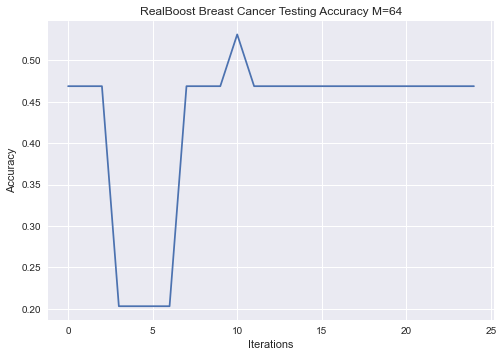

In [93]:
plot_fn(test_acc, 25, 64, ds = 'Breast Cancer', Algo= 'RealBoost', train_test = 'Testing')

y_mod [-1  1 -1  1 -1  1 -1 -1  1 -1 -1 -1  1  1  1  1 -1 -1 -1  1  1  1  1  1
  1  1 -1  1 -1  1  1  1  1  1  1  1  1  1  1 -1  1  1 -1  1 -1  1  1  1
  1  1 -1 -1 -1  1  1 -1 -1 -1 -1 -1  1 -1 -1 -1]
-----------------------ITERATION 1 -------------------------
 
Weak Hypothesis :  [1 1 1 2 1 2 1 1 2 1 1 1 2 0 2 0 1 1 1 2 2 0 2 2 2 2 1 0 1 2 2 2 0 2 2 2 0
 0 0 0 2 2 1 2 1 2 0 2 2 0 1 1 1 2 2 1 1 1 1 1 0 1 1 1]
 
Zt value :  0.2631139736326867
 
Beta values at iteration :  [1.1989473454901958, -1.6290479613185356, 8.740336755530446]
 
Beta values for each sample at iteration :  [-1.6290479613185356, -1.6290479613185356, -1.6290479613185356, 8.740336755530446, -1.6290479613185356, 8.740336755530446, -1.6290479613185356, -1.6290479613185356, 8.740336755530446, -1.6290479613185356, -1.6290479613185356, -1.6290479613185356, 8.740336755530446, 1.1989473454901958, 8.740336755530446, 1.1989473454901958, -1.6290479613185356, -1.6290479613185356, -1.6290479613185356, 8.740336755530446, 8.740336

Beta values for each sample at iteration :  [-6.7257427532744325, 1.1356025141096253, -6.7257427532744325, -6.7257427532744325, 1.1356025141096253, 0.0258719581046712, -6.7257427532744325, -6.7257427532744325, 1.1356025141096253, -6.7257427532744325, 1.1356025141096253, -6.7257427532744325, 0.0258719581046712, 0.0258719581046712, 1.1356025141096253, 0.0258719581046712, -6.7257427532744325, -6.7257427532744325, -6.7257427532744325, 1.1356025141096253, 0.0258719581046712, 0.0258719581046712, 1.1356025141096253, 1.1356025141096253, -6.7257427532744325, 1.1356025141096253, -6.7257427532744325, 0.0258719581046712, 1.1356025141096253, 1.1356025141096253, 0.0258719581046712, 1.1356025141096253, 0.0258719581046712, 1.1356025141096253, 0.0258719581046712, 1.1356025141096253, 1.1356025141096253, 0.0258719581046712, 0.0258719581046712, 0.0258719581046712, 0.0258719581046712, 1.1356025141096253, 0.0258719581046712, 0.0258719581046712, -6.7257427532744325, 1.1356025141096253, 0.0258719581046712, 1.

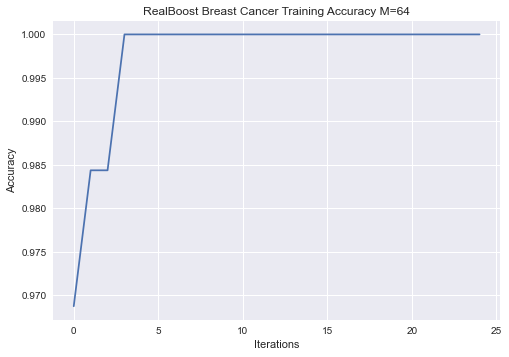

[1 2 2 1 1 1 1 1 2 0 1 0 2 2 1 1 2 2 1 2 2 1 0 1 2 2 0 0 1 2 0 1 1 0 1 1 2
 1 2 1 2 2 1 2 2 1 1 1 2 1 0 1 1 2 2 2 1 0 2 1 1 2 2 1]
[1 1 1 1 1 2 2 1 1 1 1 0 2 2 2 1 2 2 1 1 1 2 0 2 2 1 0 0 2 2 0 2 2 0 2 2 1
 1 2 1 1 0 2 2 2 2 2 2 2 2 0 2 1 2 2 2 2 0 1 1 1 2 2 1]
[2 2 2 0 2 2 2 0 2 1 2 2 2 2 1 0 2 2 0 2 2 0 2 0 2 2 2 2 0 2 2 0 0 2 1 2 2
 1 2 2 2 2 0 2 2 0 0 2 2 1 2 1 0 2 2 2 2 2 2 2 2 2 2 2]
[1 0 0 1 1 2 0 1 0 2 1 0 0 0 1 1 0 0 1 1 1 1 0 1 2 0 0 0 2 0 0 2 1 0 2 1 1
 2 0 1 1 0 1 0 0 2 1 1 0 2 0 2 1 0 0 0 1 0 0 1 1 0 0 1]
[2 2 0 2 2 2 2 2 2 2 1 0 0 0 1 2 2 2 2 0 0 2 0 2 2 2 0 0 2 2 0 2 0 0 2 0 0
 2 2 2 2 0 2 0 0 2 2 0 0 2 0 2 2 2 2 2 0 2 2 2 1 0 0 2]
[0 2 1 0 0 0 0 0 2 0 0 1 1 0 0 0 2 2 0 1 1 0 0 0 2 2 0 1 0 2 1 0 0 1 0 0 1
 0 2 0 2 1 0 1 1 0 0 0 1 0 1 0 0 2 0 2 0 0 2 0 0 1 1 0]
[1 2 2 1 1 0 0 1 2 1 1 0 0 0 0 1 0 2 1 1 2 0 0 0 2 2 0 1 0 2 1 0 0 0 0 0 2
 1 2 1 2 1 0 0 0 0 0 0 0 0 1 0 1 2 0 2 0 1 2 1 1 0 0 1]
[2 0 0 2 2 2 2 2 0 2 2 0 0 0 2 2 0 0 2 0 0 2 0 2 1 0 0 0 2 0 0 2 2 0 2 2 0
 2 0 2 0

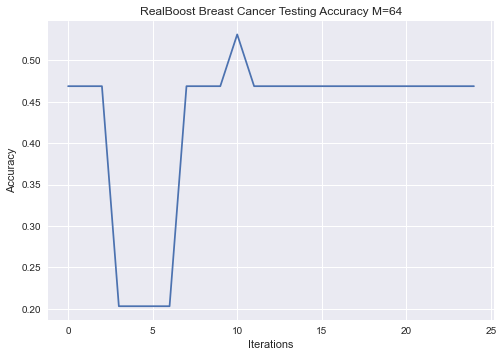

In [94]:
Dt, beta_jt, accuracies64, classifiers, Zt = realboost(X, y, T=25 ,C=3)
plot_fn(accuracies64, 25, 64, ds = 'Breast Cancer', Algo= 'RealBoost', train_test = 'Training')
beta, test_acc64 = testing(classifiers, beta_jt, X_test, y_test, 25, 4)
plot_fn(test_acc64, 25, 64, ds = 'Breast Cancer', Algo= 'RealBoost', train_test = 'Testing')

## M=32

In [95]:
X = X64[:32]
X_test = X_test64[:32]
y = y64[:32] 
y_test = y_test64[:32]

In [96]:
Dt, beta_jt, accuracies, classifiers, Zt = realboost(X, y, T=25 ,C=3)

y_mod [-1  1 -1  1 -1  1 -1 -1  1 -1 -1 -1  1  1  1  1 -1 -1 -1  1  1  1  1  1
  1  1 -1  1 -1  1  1  1]
-----------------------ITERATION 1 -------------------------
 
Weak Hypothesis :  [0 1 2 1 2 1 2 0 1 2 0 2 1 0 1 1 0 0 2 1 1 1 1 1 1 1 2 1 2 1 1 1]
 
Zt value :  0.14000427542988478
 
Beta values at iteration :  [-0.8047188282170746, 8.92265830841329, -8.517193211416236]
 
Beta values for each sample at iteration :  [-0.8047188282170746, 8.92265830841329, -8.517193211416236, 8.92265830841329, -8.517193211416236, 8.92265830841329, -8.517193211416236, -0.8047188282170746, 8.92265830841329, -8.517193211416236, -0.8047188282170746, -8.517193211416236, 8.92265830841329, -0.8047188282170746, 8.92265830841329, 8.92265830841329, -0.8047188282170746, -0.8047188282170746, -8.517193211416236, 8.92265830841329, 8.92265830841329, 8.92265830841329, 8.92265830841329, 8.92265830841329, 8.92265830841329, 8.92265830841329, -8.517193211416236, 8.92265830841329, -8.517193211416236, 8.92265830841329, 8.

Weak Hypothesis :  [2 1 2 0 2 0 2 2 0 2 2 2 0 1 0 1 2 2 2 1 0 1 0 0 1 1 2 1 2 0 1 0]
 
Zt value :  0.00024494897409973033
 
Beta values at iteration :  [8.314487633342035, 8.314406632215452, -8.31448764215446]
 
Beta values for each sample at iteration :  [-8.31448764215446, 8.314406632215452, -8.31448764215446, 8.314487633342035, -8.31448764215446, 8.314487633342035, -8.31448764215446, -8.31448764215446, 8.314487633342035, -8.31448764215446, -8.31448764215446, -8.31448764215446, 8.314487633342035, 8.314406632215452, 8.314487633342035, 8.314406632215452, -8.31448764215446, -8.31448764215446, -8.31448764215446, 8.314406632215452, 8.314487633342035, 8.314406632215452, 8.314487633342035, 8.314487633342035, 8.314406632215452, 8.314406632215452, -8.31448764215446, 8.314406632215452, -8.31448764215446, 8.314487633342035, 8.314406632215452, 8.314487633342035]
 
Strong Hypothesis :  [-1, 1, -1, 1, -1, 1, -1, -1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1]
 


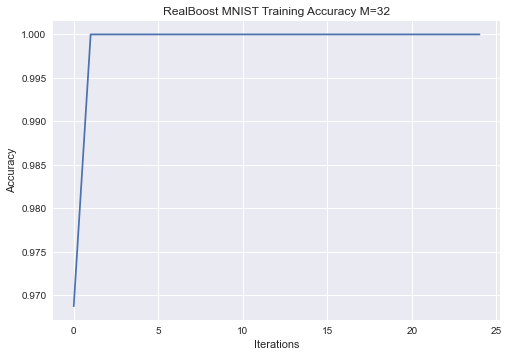

In [97]:
plot_fn(accuracies, 25, 32, ds = 'MNIST', Algo= 'RealBoost', train_test = 'Training')

In [98]:
beta, test_acc = testing(classifiers, beta_jt, X_test, y_test, 25, 4)

[0 1 1 0 0 2 1 0 1 2 0 1 1 1 2 0 1 1 0 1 1 0 0 0 1 1 0 0 0 1 0 0]
[2 1 1 2 2 2 2 2 1 2 2 1 1 1 2 2 1 1 0 1 1 0 1 0 2 1 1 1 2 1 1 2]
[0 1 1 0 0 2 2 0 1 2 0 1 2 2 2 0 1 1 0 0 1 2 2 2 1 1 2 0 2 1 2 2]
[2 1 1 0 2 2 2 0 1 2 2 1 1 2 2 0 1 1 0 1 1 0 1 0 2 1 1 1 2 1 1 2]
[0 1 2 0 0 0 0 0 1 0 0 2 2 1 0 0 1 1 0 2 2 0 2 0 1 1 2 2 0 1 2 0]
[2 0 1 2 2 2 2 2 0 2 2 1 1 0 2 2 0 0 2 1 1 2 1 2 0 0 1 1 2 0 1 2]
[2 0 1 2 2 2 2 2 0 2 2 1 1 0 2 2 0 0 2 1 1 2 1 2 0 0 1 1 2 0 1 2]
[2 0 1 2 2 2 2 2 0 2 2 1 1 0 2 2 0 0 2 1 1 2 1 2 0 0 1 1 2 0 1 2]
[2 0 1 2 2 2 2 2 0 2 2 1 1 0 2 2 0 0 2 1 1 2 1 2 0 0 1 1 2 0 1 2]
[2 0 1 2 2 2 2 2 0 2 2 1 1 0 2 2 0 0 2 1 1 2 1 2 0 0 1 1 2 0 1 2]
[2 0 1 2 2 2 2 2 0 2 2 1 1 0 2 2 0 0 2 1 1 2 1 2 0 0 1 1 2 0 1 2]
[2 0 1 2 2 2 2 2 0 2 2 1 1 0 2 2 0 0 2 1 1 2 1 2 0 0 1 1 2 0 1 2]
[2 0 1 2 2 2 2 2 0 2 2 1 1 0 2 2 0 0 2 1 1 2 1 2 0 0 1 1 2 0 1 2]
[2 0 1 2 2 2 2 2 0 2 2 1 1 0 2 2 0 0 2 1 1 2 1 2 0 0 1 1 2 0 1 2]
[2 0 1 2 2 2 2 2 0 2 2 1 1 0 2 2 0 0 2 1 1 2 1 2 0 0 1 1 2 0 1 2]
[2 0 1 2 2

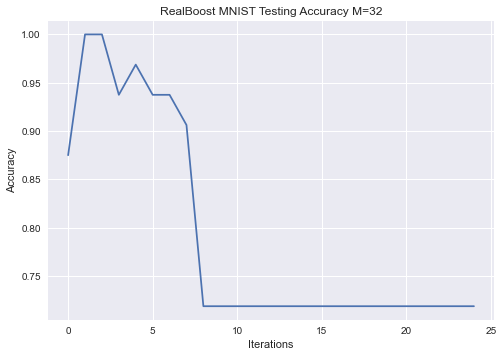

In [99]:
plot_fn(test_acc, 25, 32, ds = 'MNIST', Algo= 'RealBoost', train_test = 'Testing')

y_mod [-1  1 -1  1 -1  1 -1 -1  1 -1 -1 -1  1  1  1  1 -1 -1 -1  1  1  1  1  1
  1  1 -1  1 -1  1  1  1]
-----------------------ITERATION 1 -------------------------
 
Weak Hypothesis :  [0 1 2 1 2 1 2 0 1 2 0 2 1 0 1 1 0 0 2 1 1 1 1 1 1 1 2 1 2 1 1 1]
 
Zt value :  0.14000427542988478
 
Beta values at iteration :  [-0.8047188282170746, 8.92265830841329, -8.517193211416236]
 
Beta values for each sample at iteration :  [-0.8047188282170746, 8.92265830841329, -8.517193211416236, 8.92265830841329, -8.517193211416236, 8.92265830841329, -8.517193211416236, -0.8047188282170746, 8.92265830841329, -8.517193211416236, -0.8047188282170746, -8.517193211416236, 8.92265830841329, -0.8047188282170746, 8.92265830841329, 8.92265830841329, -0.8047188282170746, -0.8047188282170746, -8.517193211416236, 8.92265830841329, 8.92265830841329, 8.92265830841329, 8.92265830841329, 8.92265830841329, 8.92265830841329, 8.92265830841329, -8.517193211416236, 8.92265830841329, -8.517193211416236, 8.92265830841329, 8.

Weak Hypothesis :  [2 1 2 0 2 0 2 2 0 2 2 2 0 1 0 1 2 2 2 1 0 1 0 0 1 1 2 1 2 0 1 0]
 
Zt value :  0.00024494897409973033
 
Beta values at iteration :  [8.314487633342035, 8.314406632215452, -8.31448764215446]
 
Beta values for each sample at iteration :  [-8.31448764215446, 8.314406632215452, -8.31448764215446, 8.314487633342035, -8.31448764215446, 8.314487633342035, -8.31448764215446, -8.31448764215446, 8.314487633342035, -8.31448764215446, -8.31448764215446, -8.31448764215446, 8.314487633342035, 8.314406632215452, 8.314487633342035, 8.314406632215452, -8.31448764215446, -8.31448764215446, -8.31448764215446, 8.314406632215452, 8.314487633342035, 8.314406632215452, 8.314487633342035, 8.314487633342035, 8.314406632215452, 8.314406632215452, -8.31448764215446, 8.314406632215452, -8.31448764215446, 8.314487633342035, 8.314406632215452, 8.314487633342035]
 
Strong Hypothesis :  [-1, 1, -1, 1, -1, 1, -1, -1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1]
 


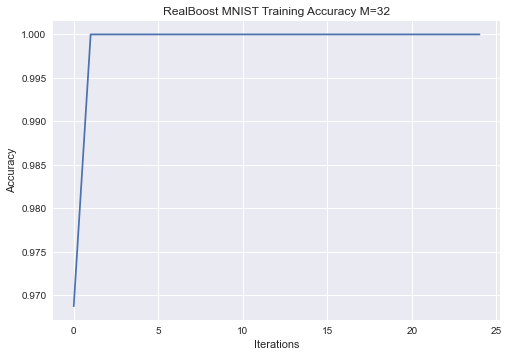

[0 1 1 0 0 2 1 0 1 2 0 1 1 1 2 0 1 1 0 1 1 0 0 0 1 1 0 0 0 1 0 0]
[2 1 1 2 2 2 2 2 1 2 2 1 1 1 2 2 1 1 0 1 1 0 1 0 2 1 1 1 2 1 1 2]
[0 1 1 0 0 2 2 0 1 2 0 1 2 2 2 0 1 1 0 0 1 2 2 2 1 1 2 0 2 1 2 2]
[2 1 1 0 2 2 2 0 1 2 2 1 1 2 2 0 1 1 0 1 1 0 1 0 2 1 1 1 2 1 1 2]
[0 1 2 0 0 0 0 0 1 0 0 2 2 1 0 0 1 1 0 2 2 0 2 0 1 1 2 2 0 1 2 0]
[2 0 1 2 2 2 2 2 0 2 2 1 1 0 2 2 0 0 2 1 1 2 1 2 0 0 1 1 2 0 1 2]
[2 0 1 2 2 2 2 2 0 2 2 1 1 0 2 2 0 0 2 1 1 2 1 2 0 0 1 1 2 0 1 2]
[2 0 1 2 2 2 2 2 0 2 2 1 1 0 2 2 0 0 2 1 1 2 1 2 0 0 1 1 2 0 1 2]
[2 0 1 2 2 2 2 2 0 2 2 1 1 0 2 2 0 0 2 1 1 2 1 2 0 0 1 1 2 0 1 2]
[2 0 1 2 2 2 2 2 0 2 2 1 1 0 2 2 0 0 2 1 1 2 1 2 0 0 1 1 2 0 1 2]
[2 0 1 2 2 2 2 2 0 2 2 1 1 0 2 2 0 0 2 1 1 2 1 2 0 0 1 1 2 0 1 2]
[2 0 1 2 2 2 2 2 0 2 2 1 1 0 2 2 0 0 2 1 1 2 1 2 0 0 1 1 2 0 1 2]
[2 0 1 2 2 2 2 2 0 2 2 1 1 0 2 2 0 0 2 1 1 2 1 2 0 0 1 1 2 0 1 2]
[2 0 1 2 2 2 2 2 0 2 2 1 1 0 2 2 0 0 2 1 1 2 1 2 0 0 1 1 2 0 1 2]
[2 0 1 2 2 2 2 2 0 2 2 1 1 0 2 2 0 0 2 1 1 2 1 2 0 0 1 1 2 0 1 2]
[2 0 1 2 2

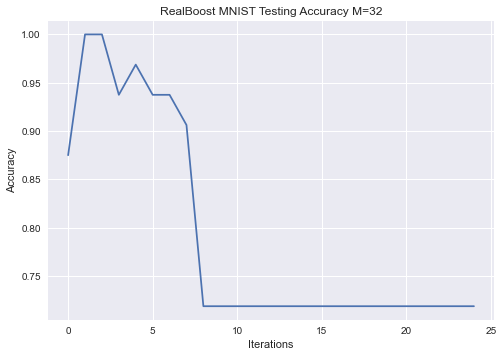

In [100]:
Dt, beta_jt, accuracies32, classifiers, Zt = realboost(X, y, T=25 ,C=3)
plot_fn(accuracies32, 25, 32, ds = 'MNIST', Algo= 'RealBoost', train_test = 'Training')
beta, test_acc32 = testing(classifiers, beta_jt, X_test, y_test, 25, 4)
plot_fn(test_acc32, 25, 32, ds = 'MNIST', Algo= 'RealBoost', train_test = 'Testing')

## M=16

In [101]:
X = X64[:16]
X_test = X_test64[:16]
y = y64[:16] 
y_test = y_test64[:16]

In [102]:
Dt, beta_jt, accuracies, classifiers, Zt = realboost(X, y, T=25 ,C=3)

y_mod [-1  1 -1  1 -1  1 -1 -1  1 -1 -1 -1  1  1  1  1]
-----------------------ITERATION 1 -------------------------
 
Weak Hypothesis :  [2 1 2 0 2 0 2 2 0 2 1 2 0 1 1 1]
 
Zt value :  0.2502323125690646
 
Beta values at iteration :  [8.517193211416236, 0.6931471205599513, -8.79700109681252]
 
Beta values for each sample at iteration :  [-8.79700109681252, 0.6931471205599513, -8.79700109681252, 8.517193211416236, -8.79700109681252, 8.517193211416236, -8.79700109681252, -8.79700109681252, 8.517193211416236, -8.79700109681252, 0.6931471205599513, -8.79700109681252, 8.517193211416236, 0.6931471205599513, 0.6931471205599513, 0.6931471205599513]
 
Strong Hypothesis :  [-1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, 1, 1]
 
Instantaneous Accuracy :  0.9375
 
-----------------------ITERATION 2 -------------------------
 
Weak Hypothesis :  [1 0 0 2 0 0 0 1 0 0 1 0 0 2 0 2]
 
Zt value :  0.013980132448188845
 
Beta values at iteration :  [3.5940550708099965, -8.863377939493304, 8.5168288220

Weak Hypothesis :  [2 0 2 0 2 0 2 1 0 2 1 2 0 0 0 0]
 
Zt value :  0.0002449489611291357
 
Beta values at iteration :  [8.314692249457227, -8.314692248692156, -8.313997091824389]
 
Beta values for each sample at iteration :  [-8.313997091824389, 8.314692249457227, -8.313997091824389, 8.314692249457227, -8.313997091824389, 8.314692249457227, -8.313997091824389, -8.314692248692156, 8.314692249457227, -8.313997091824389, -8.314692248692156, -8.313997091824389, 8.314692249457227, 8.314692249457227, 8.314692249457227, 8.314692249457227]
 
Strong Hypothesis :  [-1, 1, -1, 1, -1, 1, -1, -1, 1, -1, -1, -1, 1, 1, 1, 1]
 
Instantaneous Accuracy :  1.0
 
-----------------------ITERATION 19 -------------------------
 
Weak Hypothesis :  [2 0 2 0 2 0 2 1 0 2 1 2 0 0 0 0]
 
Zt value :  0.00024494897099064063
 
Beta values at iteration :  [8.314576470257292, -8.314576469874757, -8.31422889142001]
 
Beta values for each sample at iteration :  [-8.31422889142001, 8.314576470257292, -8.31422889142001, 8

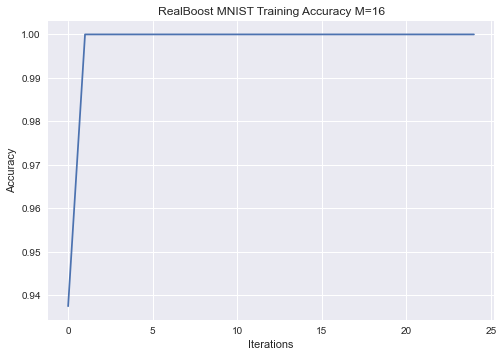

In [103]:
plot_fn(accuracies, 25, 16, ds = 'MNIST', Algo= 'RealBoost', train_test = 'Training')

In [104]:
beta, test_acc = testing(classifiers, beta_jt, X_test, y_test, 25, 4)

[2 0 0 2 2 2 2 2 0 2 2 1 1 1 2 2]
[1 2 2 1 1 0 0 1 2 0 1 2 2 0 0 1]
[2 0 0 0 2 2 0 0 0 2 2 1 0 1 2 0]
[1 0 0 1 1 0 0 1 0 0 1 2 2 0 0 1]
[2 0 0 1 1 1 0 1 0 2 1 0 0 0 2 1]
[2 1 1 2 0 0 1 2 1 0 0 1 1 1 0 2]
[1 0 0 1 2 2 0 1 0 2 1 0 0 0 2 1]
[1 0 0 1 2 2 0 1 0 2 1 0 0 0 2 1]
[1 0 0 1 2 2 0 1 0 2 1 0 0 0 2 1]
[1 0 0 1 2 2 0 1 0 2 1 0 0 0 2 1]
[1 0 0 1 2 2 0 1 0 2 1 0 0 0 2 1]
[1 0 0 1 2 2 0 1 0 2 1 0 0 0 2 1]
[1 0 0 1 2 2 0 1 0 2 1 0 0 0 2 1]
[1 0 0 1 2 2 0 1 0 2 1 0 0 0 2 1]
[1 0 0 1 2 2 0 1 0 2 1 0 0 0 2 1]
[1 0 0 1 2 2 0 1 0 2 1 0 0 0 2 1]
[1 0 0 1 2 2 0 1 0 2 1 0 0 0 2 1]
[1 0 0 1 2 2 0 1 0 2 1 0 0 0 2 1]
[1 0 0 1 2 2 0 1 0 2 1 0 0 0 2 1]
[1 0 0 1 2 2 0 1 0 2 1 0 0 0 2 1]
[1 0 0 1 2 2 0 1 0 2 1 0 0 0 2 1]
[1 0 0 1 2 2 0 1 0 2 1 0 0 0 2 1]
[1 0 0 1 2 2 0 1 0 2 1 0 0 0 2 1]
[1 0 0 1 2 2 0 1 0 2 1 0 0 0 2 1]
[1 0 0 1 2 2 0 1 0 2 1 0 0 0 2 1]


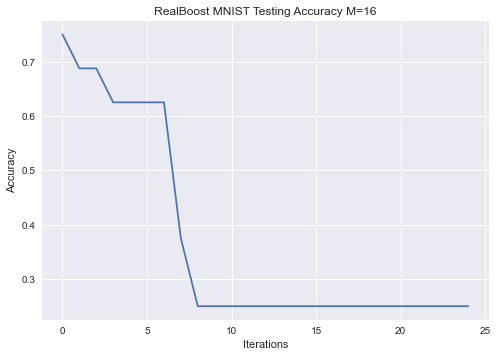

In [105]:
plot_fn(test_acc, 25, 16, ds = 'MNIST', Algo= 'RealBoost', train_test = 'Testing')

y_mod [-1  1 -1  1 -1  1 -1 -1  1 -1 -1 -1  1  1  1  1]
-----------------------ITERATION 1 -------------------------
 
Weak Hypothesis :  [2 1 2 0 2 0 2 2 0 2 1 2 0 1 1 1]
 
Zt value :  0.2502323125690646
 
Beta values at iteration :  [8.517193211416236, 0.6931471205599513, -8.79700109681252]
 
Beta values for each sample at iteration :  [-8.79700109681252, 0.6931471205599513, -8.79700109681252, 8.517193211416236, -8.79700109681252, 8.517193211416236, -8.79700109681252, -8.79700109681252, 8.517193211416236, -8.79700109681252, 0.6931471205599513, -8.79700109681252, 8.517193211416236, 0.6931471205599513, 0.6931471205599513, 0.6931471205599513]
 
Strong Hypothesis :  [-1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, 1, 1]
 
Instantaneous Accuracy :  0.9375
 
-----------------------ITERATION 2 -------------------------
 
Weak Hypothesis :  [1 0 0 2 0 0 0 1 0 0 1 0 0 2 0 2]
 
Zt value :  0.013980132448188845
 
Beta values at iteration :  [3.5940550708099965, -8.863377939493304, 8.5168288220

Weak Hypothesis :  [2 0 2 0 2 0 2 1 0 2 1 2 0 0 0 0]
 
Zt value :  0.00024494876403812144
 
Beta values at iteration :  [8.315385797978397, -8.315385794918113, -8.312605167781067]
 
Beta values for each sample at iteration :  [-8.312605167781067, 8.315385797978397, -8.312605167781067, 8.315385797978397, -8.312605167781067, 8.315385797978397, -8.312605167781067, -8.315385794918113, 8.315385797978397, -8.312605167781067, -8.315385794918113, -8.312605167781067, 8.315385797978397, 8.315385797978397, 8.315385797978397, 8.315385797978397]
 
Strong Hypothesis :  [-1, 1, -1, 1, -1, 1, -1, -1, 1, -1, -1, -1, 1, 1, 1, 1]
 
Instantaneous Accuracy :  1.0
 
-----------------------ITERATION 17 -------------------------
 
Weak Hypothesis :  [2 0 2 0 2 0 2 1 0 2 1 2 0 0 0 0]
 
Zt value :  0.0002449489216938053
 
Beta values at iteration :  [8.314923646849154, -8.314923645319011, -8.313533331666955]
 
Beta values for each sample at iteration :  [-8.313533331666955, 8.314923646849154, -8.313533331666955

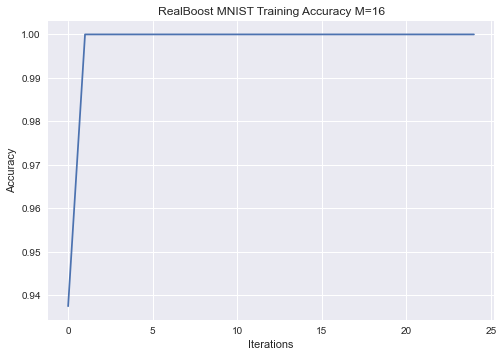

[2 0 0 2 2 2 2 2 0 2 2 1 1 1 2 2]
[1 2 2 1 1 0 0 1 2 0 1 2 2 0 0 1]
[2 0 0 0 2 2 0 0 0 2 2 1 0 1 2 0]
[1 0 0 1 1 0 0 1 0 0 1 2 2 0 0 1]
[2 0 0 1 1 1 0 1 0 2 1 0 0 0 2 1]
[2 1 1 2 0 0 1 2 1 0 0 1 1 1 0 2]
[1 0 0 1 2 2 0 1 0 2 1 0 0 0 2 1]
[1 0 0 1 2 2 0 1 0 2 1 0 0 0 2 1]
[1 0 0 1 2 2 0 1 0 2 1 0 0 0 2 1]
[1 0 0 1 2 2 0 1 0 2 1 0 0 0 2 1]
[1 0 0 1 2 2 0 1 0 2 1 0 0 0 2 1]
[1 0 0 1 2 2 0 1 0 2 1 0 0 0 2 1]
[1 0 0 1 2 2 0 1 0 2 1 0 0 0 2 1]
[1 0 0 1 2 2 0 1 0 2 1 0 0 0 2 1]
[1 0 0 1 2 2 0 1 0 2 1 0 0 0 2 1]
[1 0 0 1 2 2 0 1 0 2 1 0 0 0 2 1]
[1 0 0 1 2 2 0 1 0 2 1 0 0 0 2 1]
[1 0 0 1 2 2 0 1 0 2 1 0 0 0 2 1]
[1 0 0 1 2 2 0 1 0 2 1 0 0 0 2 1]
[1 0 0 1 2 2 0 1 0 2 1 0 0 0 2 1]
[1 0 0 1 2 2 0 1 0 2 1 0 0 0 2 1]
[1 0 0 1 2 2 0 1 0 2 1 0 0 0 2 1]
[1 0 0 1 2 2 0 1 0 2 1 0 0 0 2 1]
[1 0 0 1 2 2 0 1 0 2 1 0 0 0 2 1]
[1 0 0 1 2 2 0 1 0 2 1 0 0 0 2 1]


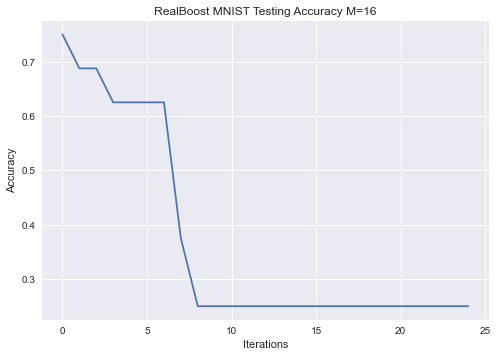

In [106]:
Dt, beta_jt, accuracies16, classifiers, Zt = realboost(X, y, T=25 ,C=3)

plot_fn(accuracies16, 25, 16, ds = 'MNIST', Algo= 'RealBoost', train_test = 'Training')

beta, test_acc16 = testing(classifiers, beta_jt, X_test, y_test, 25, 4)

plot_fn(test_acc16, 25, 16, ds = 'MNIST', Algo= 'RealBoost', train_test = 'Testing')

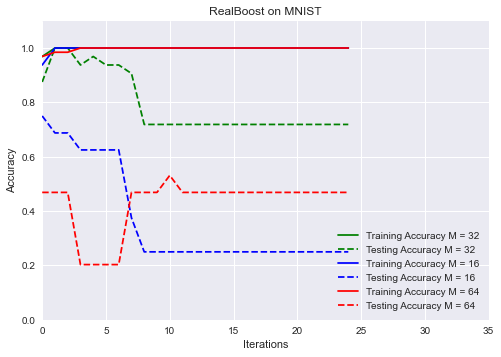

In [111]:
plt.style.use('seaborn')
plt.plot(list(range(25)), accuracies32, "g-", label = "Training Accuracy M = 32")
plt.plot(list(range(25)), test_acc32, "g--", label = "Testing Accuracy M = 32")

plt.plot(list(range(25)), accuracies16, "b-", label = "Training Accuracy M = 16")
plt.plot(list(range(25)), test_acc16, "b--", label = "Testing Accuracy M = 16")

plt.plot(list(range(25)), accuracies64, "r-", label = "Training Accuracy M = 64")
plt.plot(list(range(25)), test_acc64, "r--", label = "Testing Accuracy M = 64")

# plt.plot([], [], 'k-', label="Training Accuracy")
# plt.plot([], [], 'k--', label="Testing Accuracy")

plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.title("RealBoost on MNIST")
plt.ylim([0,1.1])
plt.xlim([0,35])

plt.show()

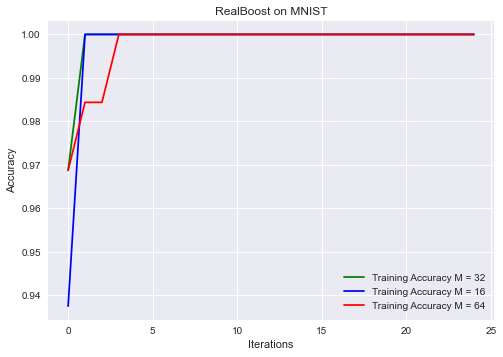

In [108]:
plt.style.use('seaborn')
plt.plot(list(range(25)), accuracies32, "g-", label = "Training Accuracy M = 32")
#plt.plot(list(range(25)), test_acc32, "g--", label = "Testing Accuracy M = 32")

plt.plot(list(range(25)), accuracies16, "b-", label = "Training Accuracy M = 16")
#plt.plot(list(range(25)), test_acc16, "b--", label = "Testing Accuracy M = 16")

plt.plot(list(range(25)), accuracies64, "r-", label = "Training Accuracy M = 64")
#plt.plot(list(range(25)), test_acc64, "r--", label = "Testing Accuracy M = 64")

# plt.plot([], [], 'k-', label="Training Accuracy")
# plt.plot([], [], 'k--', label="Testing Accuracy")

plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.title("RealBoost on MNIST")
# plt.ylim([0.5,1.1])

plt.show()